In [18]:
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
# !!!!!Process test df
test_df = pd.read_csv('datasets/summative/apartment_for_rent_test_edited.csv', encoding='utf-8')

In [20]:
test_df.columns = test_df.columns.str.lower()

In [21]:
# Convert to Monthly Rent
def convert_to_monthly_rent(row):
    if row['duration'] == 'daily':
        return row['price'] * 365 / 12
    elif row['duration']== 'monthly':
        return row['price'] 
    else:
        return None

In [22]:
# Mean price for each value of field
# Clean up leading/trailing spcaes and lower-case for comparison
def print_field_statistic(df, field):
    df_ = df.copy()
    df_[f"{field}_cleaned"] = df_[field].astype(str).str.strip().str.lower()

    # Group by the cleaned balcony values and calculate mean price
    mean_price_by_field = df_.groupby(f"{field}_cleaned")['monthly_price_usd'].agg(
        mean='mean', 
        median='median', 
        min='min', 
        max='max', 
        std='std', 
        iqr=lambda x: x.quantile(0.75) - x.quantile(0.25), 
        count='count'
    ).sort_values(by='mean', ascending=False)

    # Display the results
    print(mean_price_by_field)

In [23]:
# Convert to USD (from other currencies)
exchange_rates = { 'USD': 1.00,
                  'EUR': 1.10,
                  'RUB': 0.013,
                  'AMD': 0.0026
                 }

In [24]:
 # Function to Show Unique Values in a Column
def show_unique_values(df, column_name):
    if column_name in df.columns:
        unique_vals = set(df[column_name].dropna().unique())
        print(f"Unique values in '{column_name}':")
        print(unique_vals)
    else: 
        print(f"Column '{column_name}' not found in DataFrame.")

In [25]:
# String Cleaning Function
# replace space with _, remove leading and tailing space and _
def clean_str(val):
    if pd.isna(val):
        return val
    return str(val).strip().lower().replace(" ", "_").strip("_")

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_boxplot_by_category(df, column_name):
    """
    Plots boxplot of monthly_price_usd against a categorical column,
    dropping NaNs in that column.

    Parameters:
        df (pd.DataFrame): The DataFrame containing your data
        column_name (str): Name of the categorical column to plot
    """
    data = df.dropna(subset=[column_name, 'log_price'])
    data = data[data[column_name].astype(str).str.lower() != 'nan'] # Drop string 'nan'
    plt.figure(figsize=(14, 6))
    sns.boxplot(x=column_name, y='log_price', data=data)
    plt.title(f'Log(1 + Monthly Rent in USD) by {column_name.replace("_", " ").title()}')
    plt.xlabel(column_name.replace("_", " ").title())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.tight_layout()
    plt.show()

In [27]:
# Convert 'balcony_cleaned', 'utility_payments', 'children_are_welcome', 'pets_allowed', 'parking' to binary
def convert_to_binary_fields(df, binary_fields):
    for col in binary_fields:
        if col == 'balcony':
            df[f"{col}_binary"] = df[col].apply(lambda x: 0 if 'not_available' in str(x).lower() else 1)
        elif col in ['parking', 'appliances', 'amenities']:
            df[f"{col}_binary"] = df[f"{col}_none"].apply(lambda x: 0 if x==1 else 1)
        elif col == 'gender':
            df[f"{col}_binary"] = df[col].apply(lambda x: 0 if x=='female' else 1)
        elif col == 'duration':
            df[f"{col}_binary"] = df[col].apply(lambda x: 0 if x=='daily' else 1)
        else:
            df[f"{col}_binary"] = df[col].apply(lambda x: 0 if x == 0 else 1)

In [28]:
from scipy.stats import ttest_ind, t
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def run_ttest_and_plot(df, column_name, target='log_price', plot=True, conf_level=0.95):
    # Drop missing values
    df_valid = df[[column_name, target]].dropna()

    # Split into two groups
    group0 = df_valid[df_valid[column_name] == 0][target]
    group1 = df_valid[df_valid[column_name] == 1][target]

    # Sizes
    n0, n1 = len(group0), len(group1)

    # Means and medians
    mean0, mean1 = group0.mean(), group1.mean()
    median0, median1 = group0.median(), group1.median()

    # Standard deviation and standard error
    std0, std1 = group0.std(), group1.std()
    se0, se1 = std0 / np.sqrt(n0), std1 / np.sqrt(n1)

    # Pooled standard deviation
    pooled_std = np.sqrt(((n0 - 1) * std0**2 + (n1 - 1) * std1**2) / (n0 + n1 - 2))

    # T-test (Welch)
    t_stat, p_val = ttest_ind(group0, group1, equal_var=False)
    t_squared = t_stat ** 2

    # Degrees of freedom (Welch-Satterthwaite)
    df_val = (se0**2 + se1**2)**2 / ((se0**4 / (n0 - 1)) + (se1**4 / (n1 - 1)))

    # Confidence Interval for difference in means
    pooled_se = np.sqrt(se0**2 + se1**2)
    t_crit = t.ppf(1 - (1 - conf_level) / 2, df_val)
    mean_diff = mean1 - mean0
    ci_low = mean_diff - t_crit * pooled_se
    ci_high = mean_diff + t_crit * pooled_se

    # Report
    print(f"\n--- Two-Sample T-Test for '{column_name}' vs. {target} ---")
    print(f"Group 0 → Mean: {mean0:.4f}, Median: {median0:.4f}, StDev: {std0:.4f}, SE: {se0:.4f}, n = {n0}")
    print(f"Group 1 → Mean: {mean1:.4f}, Median: {median1:.4f}, StDev: {std1:.4f}, SE: {se1:.4f}, n = {n1}")
    print(f"Pooled Std Dev: {pooled_std:.4f}")
    print(f"Mean difference: {abs(mean_diff):.4f}")
    print(f"Median difference: {abs(median1 - median0):.4f}")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"T-squared (≈ F): {t_squared:.4f}")
    print(f"Degrees of freedom (df): {round(df_val)}")
    print(f"{int(conf_level*100)}% CI for difference: ({ci_low:.4f}, {ci_high:.4f})")
    print(f"P-value: {p_val:.4g}")
    print("Statistically significant?", "Yes (p < 0.05)" if p_val < 0.05 else "No")

    # Optional boxplot
    if plot:
        plt.figure(figsize=(6, 4))
        sns.boxplot(x=column_name, y=target, data=df_valid)
        plt.title(f"Boxplot of {target} by {column_name}")
        plt.xlabel(column_name)
        plt.ylabel('Log(1 + Monthly Rent in USD)')
        if column_name == 'gender_binary':
            plt.xticks([0, 1], ['Female / 0', 'Male / 1'])
        elif column_name == 'duration_binary':
            plt.xticks([0, 1], ['Daily / 0', 'Monthly / 1'])
        else:
            plt.xticks([0, 1], ['Not Available / 0', 'Available / 1'])
        plt.tight_layout()
        plt.show()

    return {
        'column': column_name,
        'mean_diff': mean_diff,
        'median_diff': median1 - median0,
        't_stat': t_stat,
        't_squared': t_squared,
        'df': df_val,
        'std0': std0,
        'std1': std1,
        'pooled_std': pooled_std,
        'se0': se0,
        'se1': se1,
        'ci': (ci_low, ci_high),
        'p_value': p_val,
        'significant': p_val < 0.05
    }


In [29]:
test_df['monthly_price'] = test_df.apply(convert_to_monthly_rent, axis=1)

In [30]:
# Map rates ti each row
test_df['exchange_rate'] = test_df['currency'].map(exchange_rates)

# Multiply to get USD rent
test_df['monthly_price_usd'] = test_df['monthly_price'] * test_df['exchange_rate']

In [31]:
columns_to_clean = [
    'construction_type', 'balcony', 'furniture',
    'renovation', 'duration'
]
for col in columns_to_clean:
    test_df[col] = test_df[col].apply(clean_str)

In [32]:
#1. Descriptive Statistics (Quantiles)
print(test_df['monthly_price_usd'].describe(percentiles=[.90, .95, .98, .99, .999]))

count    8.147000e+03
mean     2.300183e+03
std      2.605052e+04
min      2.080000e-01
50%      1.250000e+03
90%      2.372500e+03
95%      3.000000e+03
98%      4.000000e+03
99%      5.186583e+03
99.9%    3.397800e+05
max      1.520833e+06
Name: monthly_price_usd, dtype: float64


In [33]:
# Export translated DataFrame to CSV
test_df.to_csv('check_test_df.csv', index=False, encoding='utf-8-sig')

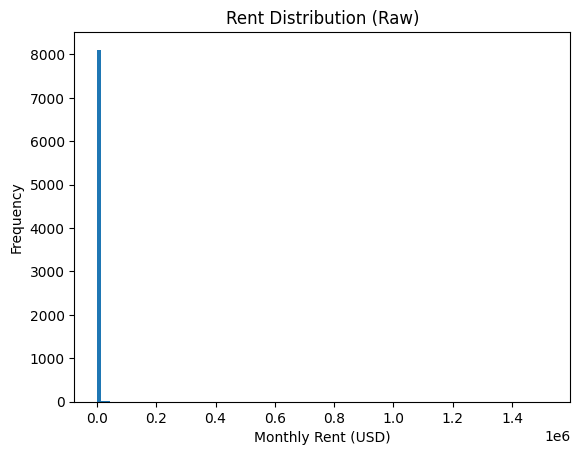

In [34]:
#2. Histogram
# See the shape of rent distribution:
import matplotlib.pyplot as plt

plt.hist(test_df['monthly_price_usd'], bins=100)
plt.title('Rent Distribution (Raw)')
plt.xlabel('Monthly Rent (USD)')
plt.ylabel('Frequency')
plt.show()

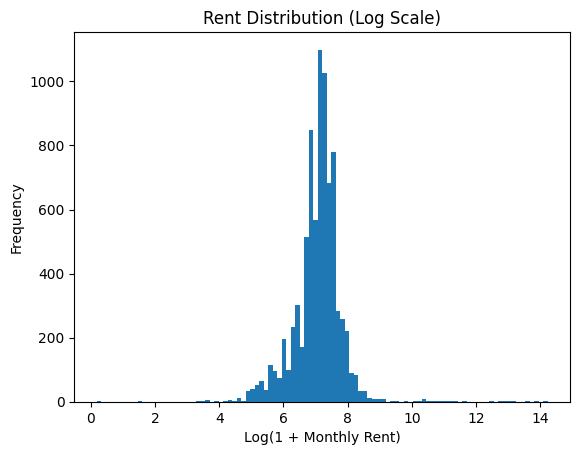

In [35]:
import numpy as np

plt.hist(np.log1p(test_df['monthly_price_usd']), bins=100)
plt.title('Rent Distribution (Log Scale)')
plt.xlabel('Log(1 + Monthly Rent)')
plt.ylabel('Frequency')
plt.show()

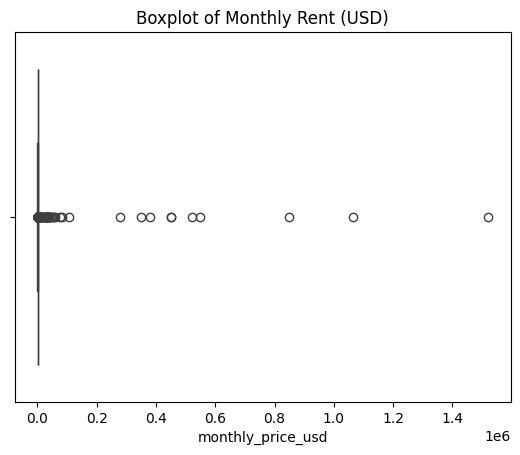

In [36]:
# 3. Boxplot (Detect Outliers Visually)
# Boxplots highlight IQR, outliers, and skew:
import seaborn as sns

sns.boxplot(x=test_df['monthly_price_usd'])
plt.title('Boxplot of Monthly Rent (USD)')
plt.show()

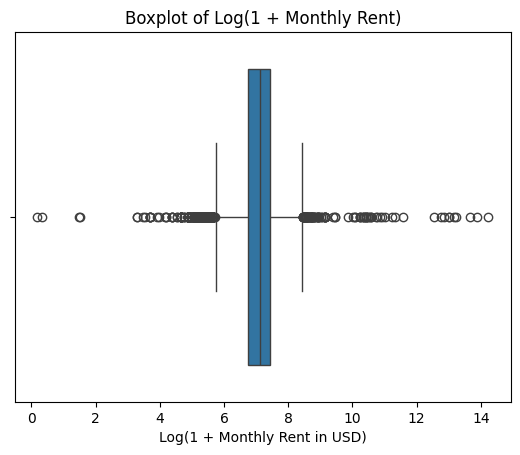

In [37]:
import numpy as np
sns.boxplot(x=np.log1p(test_df['monthly_price_usd']))
plt.title('Boxplot of Log(1 + Monthly Rent)')
plt.xlabel('Log(1 + Monthly Rent in USD)')
plt.show()

In [38]:
test_df['log_price'] = np.log1p(test_df['monthly_price_usd'])

In [39]:
#  Drop rows with number of rooms == 0
test_df = test_df[test_df['number_of_rooms'] != 0]

In [40]:
print(test_df['number_of_bathrooms'].value_counts())

number_of_bathrooms
1    6573
2    1360
3     212
0       1
Name: count, dtype: int64


In [41]:
#  Drop rows with number of bathrooms == 0
test_df = test_df[test_df['number_of_bathrooms'] != 0]

In [42]:
print(test_df['floor'].value_counts())

floor
2     1327
3     1310
4     1099
5      845
1      759
6      532
7      466
8      453
9      342
10     248
12     207
11     170
13     121
14     108
15      78
17      40
16      31
18       5
21       2
20       1
22       1
Name: count, dtype: int64


In [43]:
# Check for invalid floor 
invalid_floors = test_df[test_df['floor']> test_df['floors_in_the_building']]
print(invalid_floors[['floor', 'floors_in_the_building']])
print(f"Number of invalid rows: {invalid_floors.shape[0]}")

Empty DataFrame
Columns: [floor, floors_in_the_building]
Index: []
Number of invalid rows: 0


In [44]:
# Furniture
print(test_df['furniture'].value_counts())

furniture
available            4189
by_agreement           71
not_available          71
partial_furniture      27
Name: count, dtype: int64


In [45]:
# Print furniture statistics
print_field_statistic(test_df, 'furniture')

                          mean  median      min           max           std  \
furniture_cleaned                                                             
nan                2784.596565  1400.0    3.380  1.520833e+06  31823.267500   
available          1920.282778  1200.0    0.208  1.064583e+06  20100.199004   
by_agreement       1150.248826  1200.0  143.000  3.000000e+03    688.692651   
not_available       817.290376   650.0   63.700  4.000000e+03    734.879441   
partial_furniture   272.518519   260.0   78.000  7.800000e+02    140.684965   

                          iqr  count  
furniture_cleaned                     
nan                850.000000   3787  
available          801.666667   4189  
by_agreement       984.000000     71  
not_available      879.125000     71  
partial_furniture  143.000000     27  


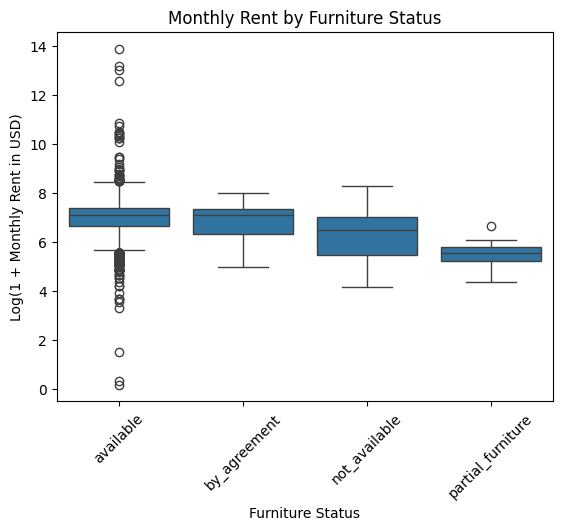

In [46]:
#  Boxplot of Rent by Furniture Type
sns.boxplot(x='furniture', y='log_price', data=test_df)
plt.title('Monthly Rent by Furniture Status')
plt.xlabel('Furniture Status')
plt.ylabel('Log(1 + Monthly Rent in USD)')
plt.xticks(rotation=45)
plt.show()

In [47]:
# Replace missing values with 'available' in furniture
test_df['furniture'] = test_df['furniture'].fillna('available')

In [48]:
# Print furniture statistics
print_field_statistic(test_df, 'furniture')

                          mean  median      min           max           std  \
furniture_cleaned                                                             
available          2330.658444  1300.0    0.208  1.520833e+06  26327.268618   
by_agreement       1150.248826  1200.0  143.000  3.000000e+03    688.692651   
not_available       817.290376   650.0   63.700  4.000000e+03    734.879441   
partial_furniture   272.518519   260.0   78.000  7.800000e+02    140.684965   

                       iqr  count  
furniture_cleaned                  
available          800.000   7976  
by_agreement       984.000     71  
not_available      879.125     71  
partial_furniture  143.000     27  


In [49]:
print(test_df['renovation'].value_counts())

renovation
major_renovation       2914
designer_renovation    2353
euro_renovation        2001
cosmetic_renovation     552
partial_renovation      171
old_renovation          141
no_renovation            13
Name: count, dtype: int64


In [50]:
print(test_df['duration'].value_counts())

duration
monthly    6709
daily      1436
Name: count, dtype: int64


In [51]:
print_field_statistic(test_df, 'number_of_rooms')

                                mean       median         min           max  \
number_of_rooms_cleaned                                                       
5                        5259.486979  2255.000000  143.000000  3.800000e+05   
7                        3554.380000  4750.000000   33.800000  5.500000e+03   
6                        3489.267361  3000.000000  130.000000  8.699167e+03   
4                        3225.971804  1800.000000  130.000000  8.500000e+05   
3                        2852.875269  1400.000000    0.208000  1.520833e+06   
8                        2415.979167  2285.833333  553.583333  5.000000e+03   
2                        1730.608963  1170.000000   26.000000  5.500000e+05   
1                        1157.523895   800.000000    0.390000  4.745000e+04   

                                  std       iqr  count  
number_of_rooms_cleaned                                 
5                        33410.071799  1607.375    128  
7                         2243.387087 

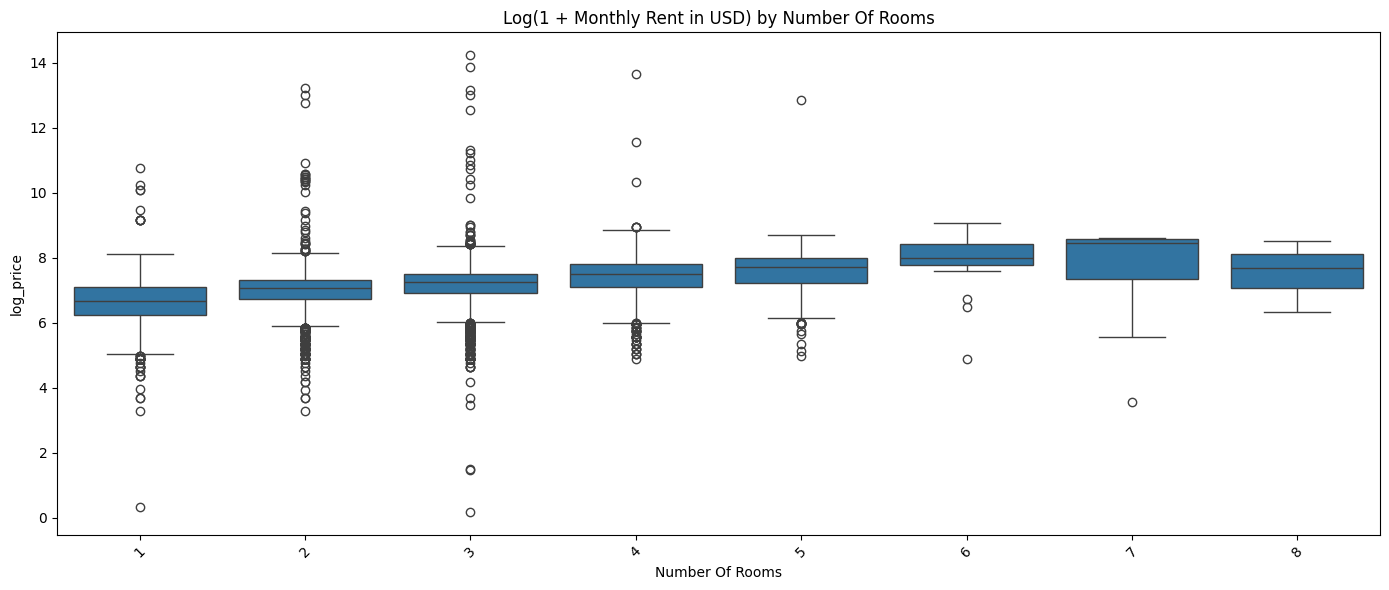

In [52]:
# Number of rooms
plot_boxplot_by_category(test_df, 'number_of_rooms')

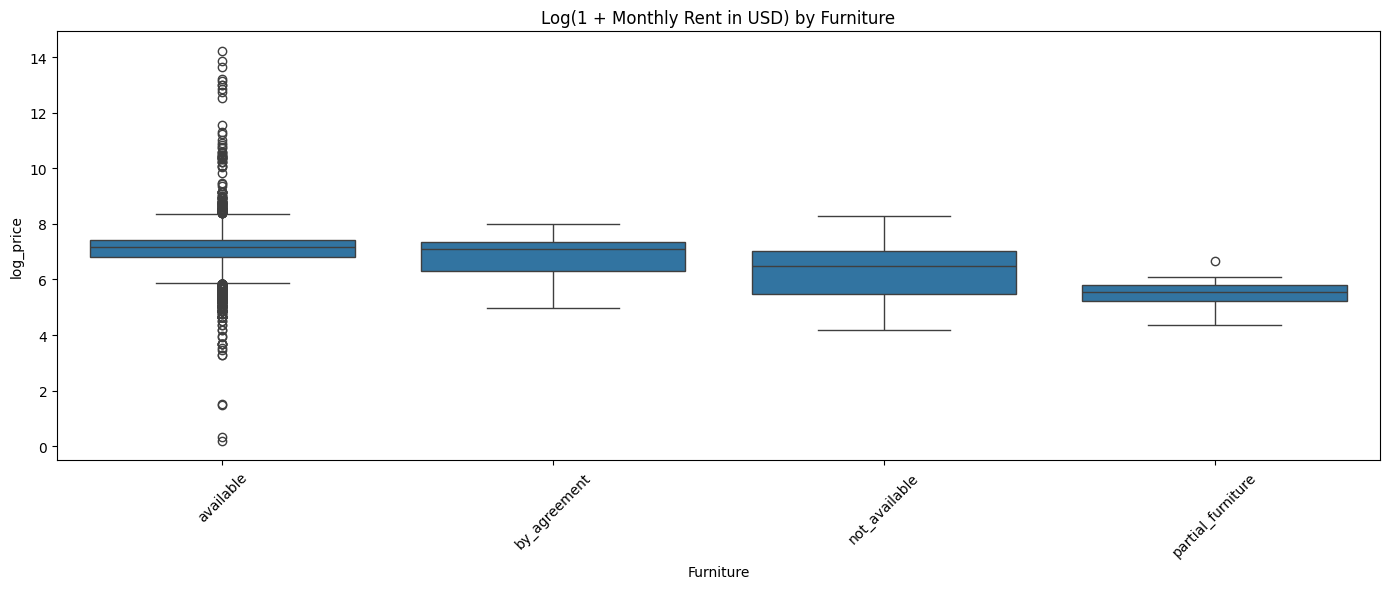

In [53]:
# Furniture
plot_boxplot_by_category(test_df, 'furniture')

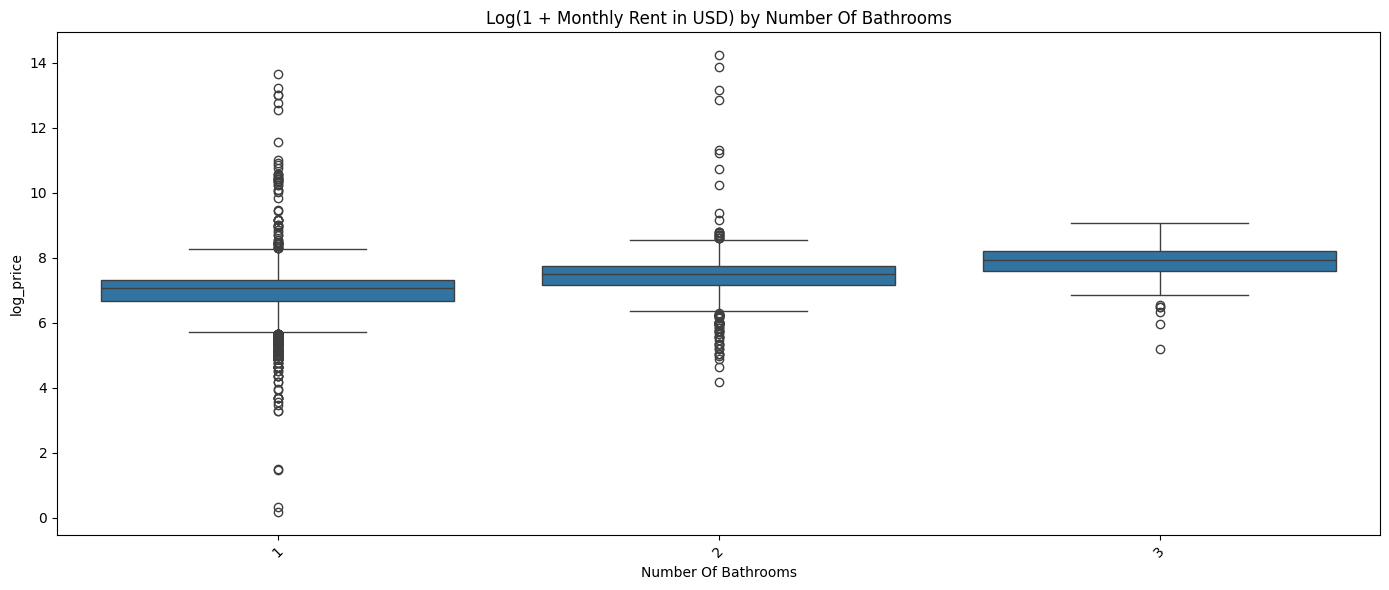

In [54]:
# Number of bathrooms
plot_boxplot_by_category(test_df, 'number_of_bathrooms')

In [55]:
print_field_statistic(test_df, 'number_of_bathrooms')

                                    mean   median      min           max  \
number_of_bathrooms_cleaned                                                
2                            4626.943642  1800.00   65.000  1.520833e+06   
3                            3023.171777  2800.00  182.000  8.699167e+03   
1                            1795.653318  1186.25    0.208  8.500000e+05   

                                      std     iqr  count  
number_of_bathrooms_cleaned                               
2                            53250.284819  1000.0   1360  
3                             1420.769575  1687.5    212  
1                            15916.746754   720.0   6573  


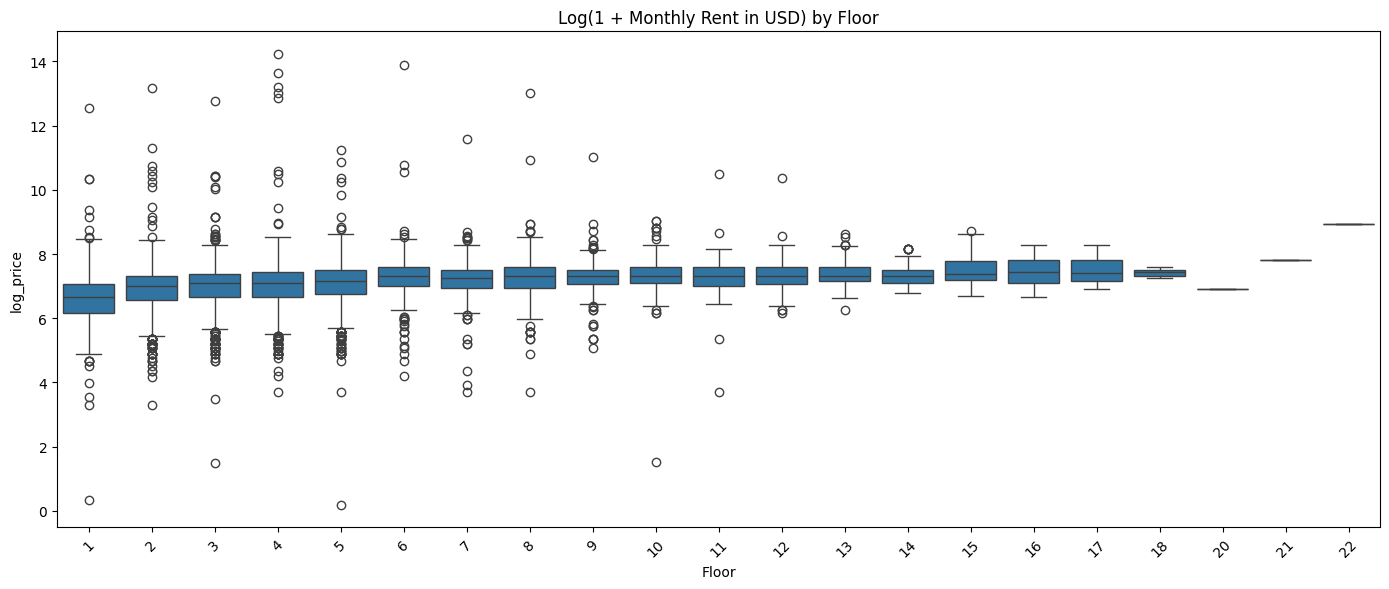

In [56]:
# floor
plot_boxplot_by_category(test_df, 'floor')

In [57]:
print_field_statistic(test_df, 'floor')

                      mean       median          min           max  \
floor_cleaned                                                        
22             7604.166667  7604.166667  7604.166667  7.604167e+03   
4              4809.637950  1200.000000    39.000000  1.520833e+06   
6              3759.796209  1500.000000    65.000000  1.064583e+06   
8              2754.065305  1500.000000    39.000000  4.500000e+05   
21             2500.000000  2500.000000  2500.000000  2.500000e+03   
15             1973.435897  1580.000000   800.000000  6.083333e+03   
17             1917.239583  1650.000000  1000.000000  4.000000e+03   
16             1863.731183  1700.000000   780.000000  4.000000e+03   
13             1782.376033  1500.000000   520.000000  5.475000e+03   
11             1767.173529  1500.000000    39.000000  3.558750e+04   
12             1761.427536  1500.000000   468.000000  3.163333e+04   
7              1758.648569  1400.000000    39.000000  1.064583e+05   
10             1757.

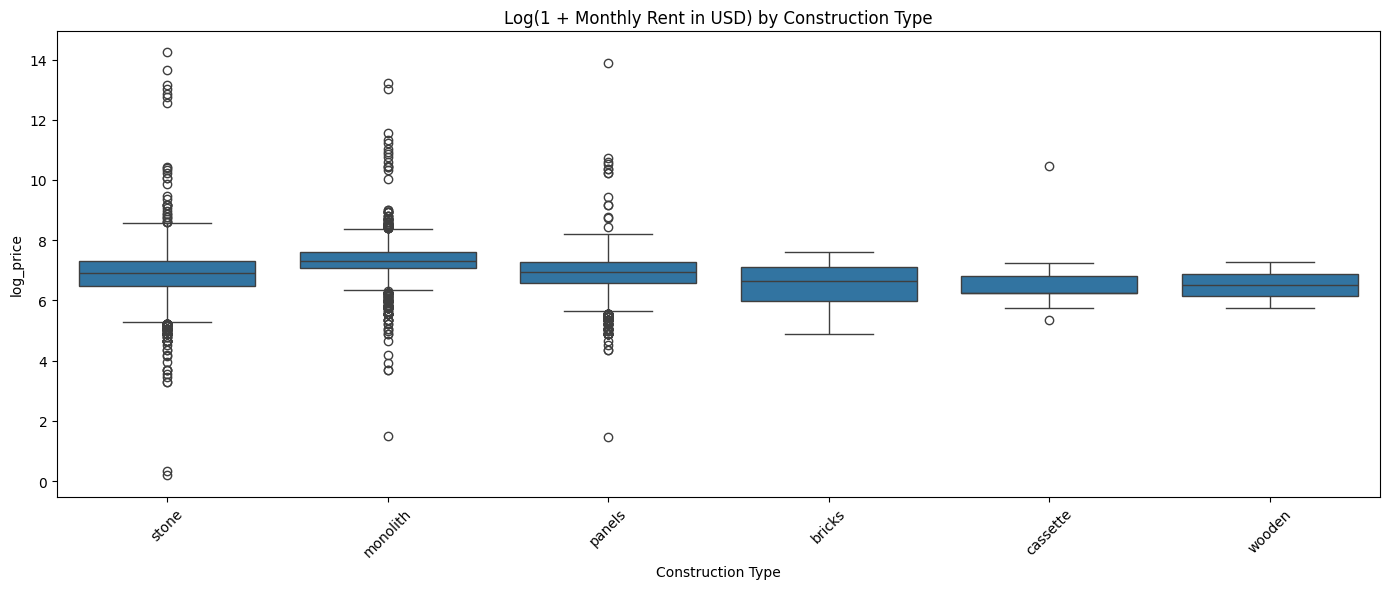

In [58]:
# Construction type
plot_boxplot_by_category(test_df, 'construction_type')

In [59]:
print_field_statistic(test_df, 'construction_type')

                                  mean       median         min           max  \
construction_type_cleaned                                                       
cassette                   4140.750000   520.000000  208.000000  3.558750e+04   
stone                      2567.668975  1000.000000    0.208000  1.520833e+06   
monolith                   2162.250978  1500.000000    3.510000  5.500000e+05   
panels                     2057.598324  1040.000000    3.380000  1.064583e+06   
wooden                      869.916667   869.916667  316.333333  1.423500e+03   
bricks                      852.653226   780.000000  130.000000  2.000000e+03   

                                    std         iqr  count  
construction_type_cleaned                                   
cassette                   11054.664469  390.000000     10  
stone                      34727.123402  850.000000   3189  
monolith                   12405.694655  800.000000   3531  
panels                     28713.799664  695.5

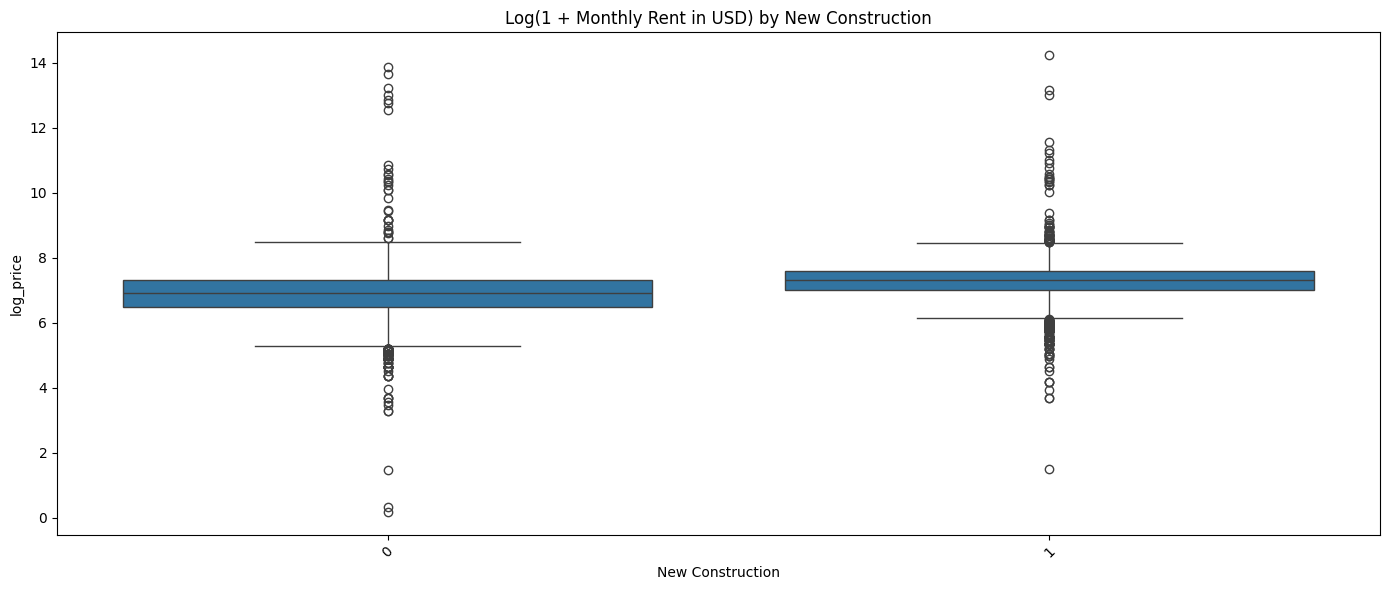

In [60]:
# New Construction
plot_boxplot_by_category(test_df, 'new_construction')

In [61]:
print_field_statistic(test_df, 'new_construction')

                                 mean  median    min           max  \
new_construction_cleaned                                             
1                         2451.344624  1500.0  3.510  1.520833e+06   
0                         2155.288550  1020.5  0.208  1.064583e+06   

                                   std         iqr  count  
new_construction_cleaned                                   
1                         26586.753334  892.833333   3991  
0                         25533.464317  850.000000   4154  


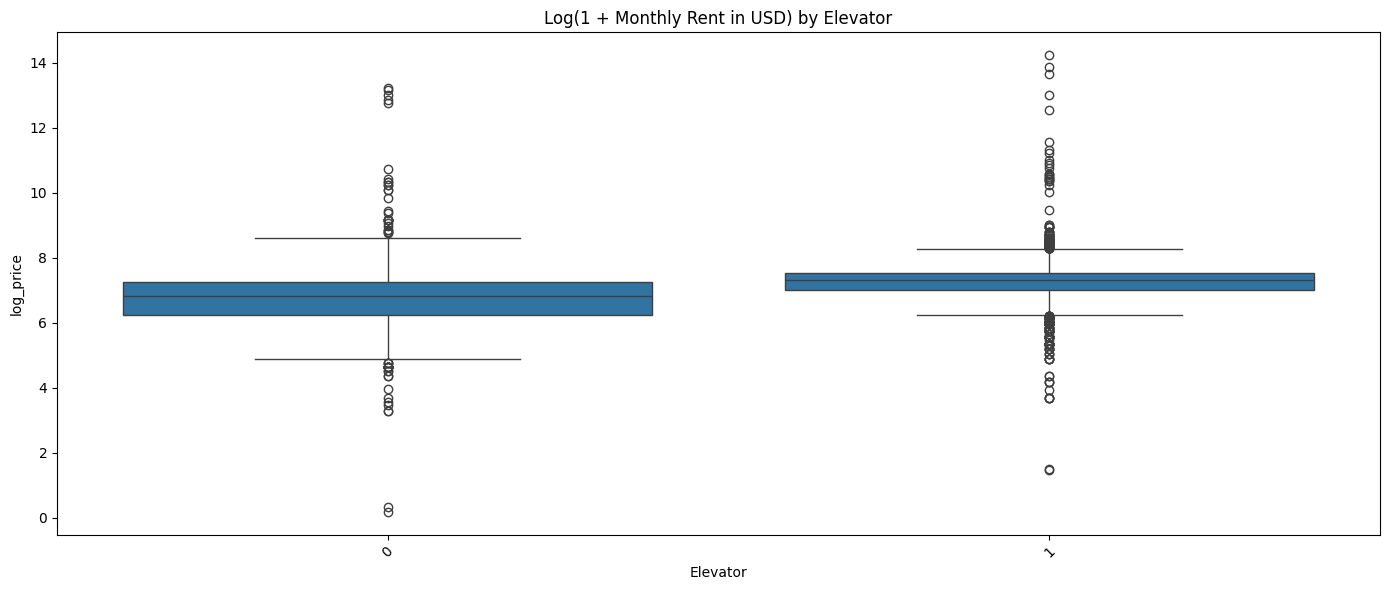

In [62]:
# Elevator
plot_boxplot_by_category(test_df, 'elevator')

In [63]:
print_field_statistic(test_df, 'elevator')

                         mean  median    min           max           std  \
elevator_cleaned                                                           
1                 2615.818620  1500.0  3.380  1.520833e+06  30287.880255   
0                 1827.399588   910.0  0.208  5.500000e+05  17914.730679   

                     iqr  count  
elevator_cleaned                 
1                 743.75   4886  
0                 880.00   3259  


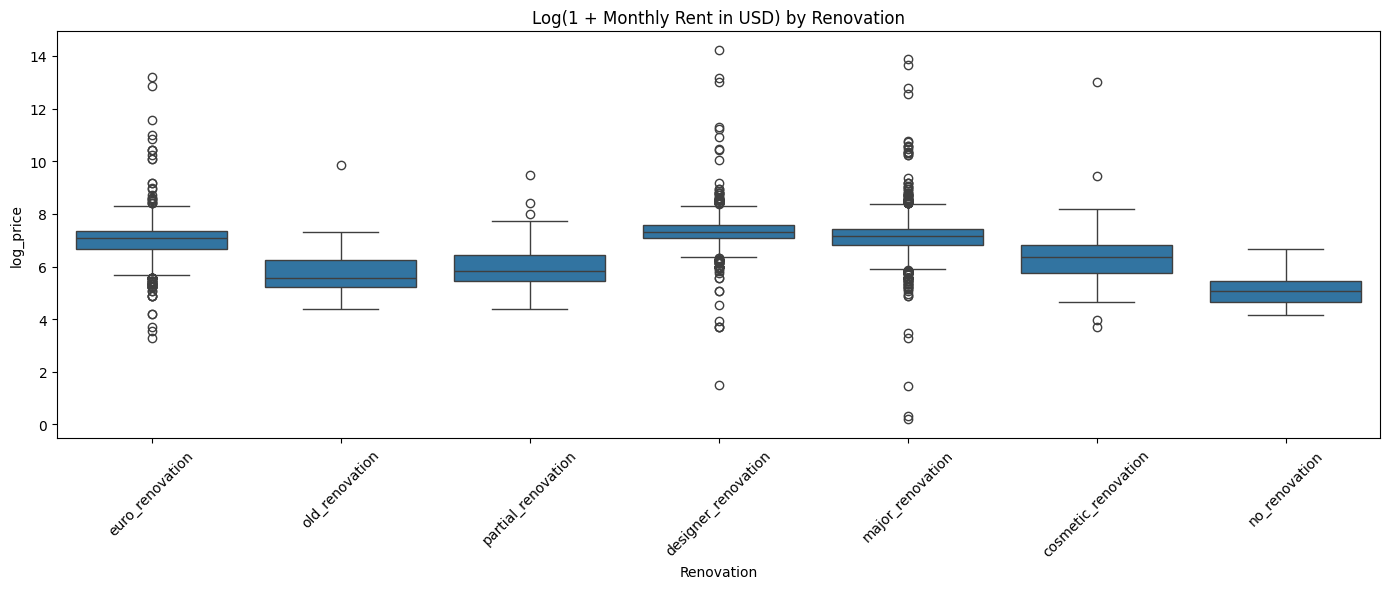

In [64]:
# Renovation
plot_boxplot_by_category(test_df, 'renovation')

In [65]:
print_field_statistic(test_df, 'renovation')

                            mean   median     min           max           std  \
renovation_cleaned                                                              
designer_renovation  2833.251532  1500.00   3.510  1.520833e+06  34462.799476   
major_renovation     2462.636421  1300.00   0.208  1.064583e+06  26613.337418   
euro_renovation      1938.331774  1186.25  26.000  5.500000e+05  15277.439579   
cosmetic_renovation  1523.362772   572.00  39.000  4.500000e+05  19136.530491   
partial_renovation    559.548148   338.00  78.000  1.300000e+04   1077.108512   
old_renovation        535.858747   260.00  78.000  1.898000e+04   1596.638764   
no_renovation         221.900000   156.00  63.700  7.800000e+02    190.667197   

                            iqr  count  
renovation_cleaned                      
designer_renovation  777.083333   2353  
major_renovation     792.250000   2914  
euro_renovation      788.666667   2001  
cosmetic_renovation  598.000000    552  
partial_renovation   405

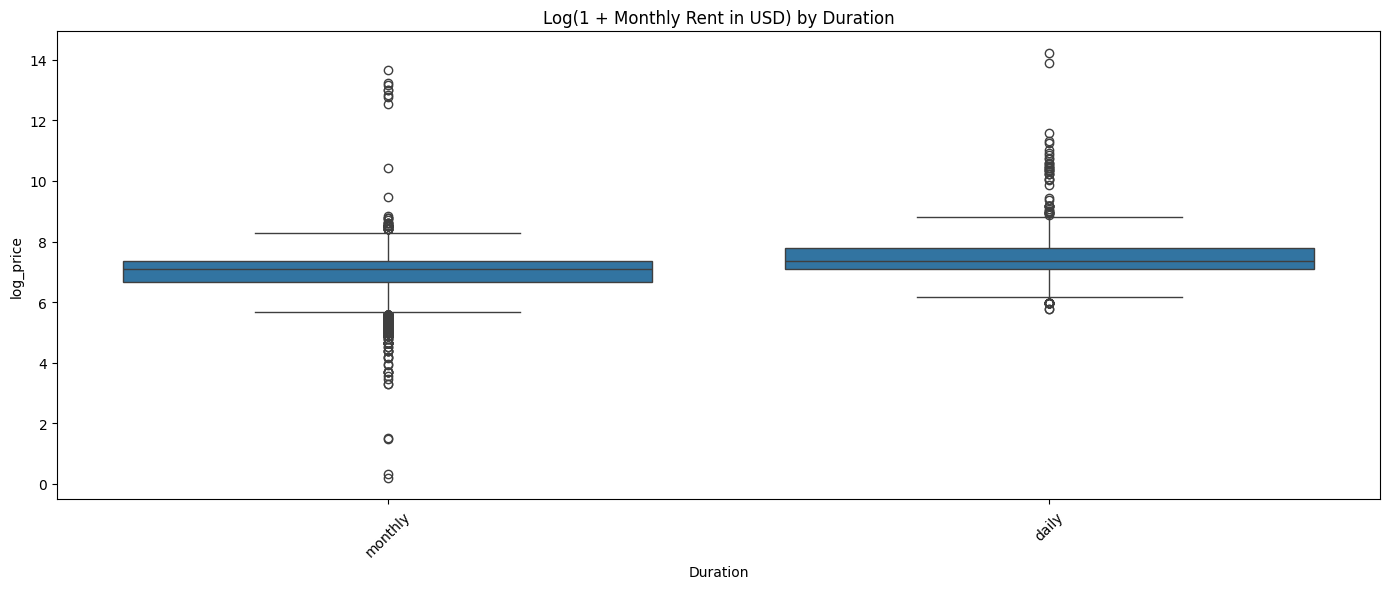

In [66]:
# duration
plot_boxplot_by_category(test_df, 'duration')

In [67]:
print_field_statistic(test_df, 'duration')

                         mean       median         min           max  \
duration_cleaned                                                       
daily             4484.622209  1581.666667  316.333333  1.520833e+06   
monthly           1832.831650  1200.000000    0.208000  8.500000e+05   

                           std      iqr  count  
duration_cleaned                                
daily             49254.494203  1186.25   1436  
monthly           17432.369163   780.00   6709  


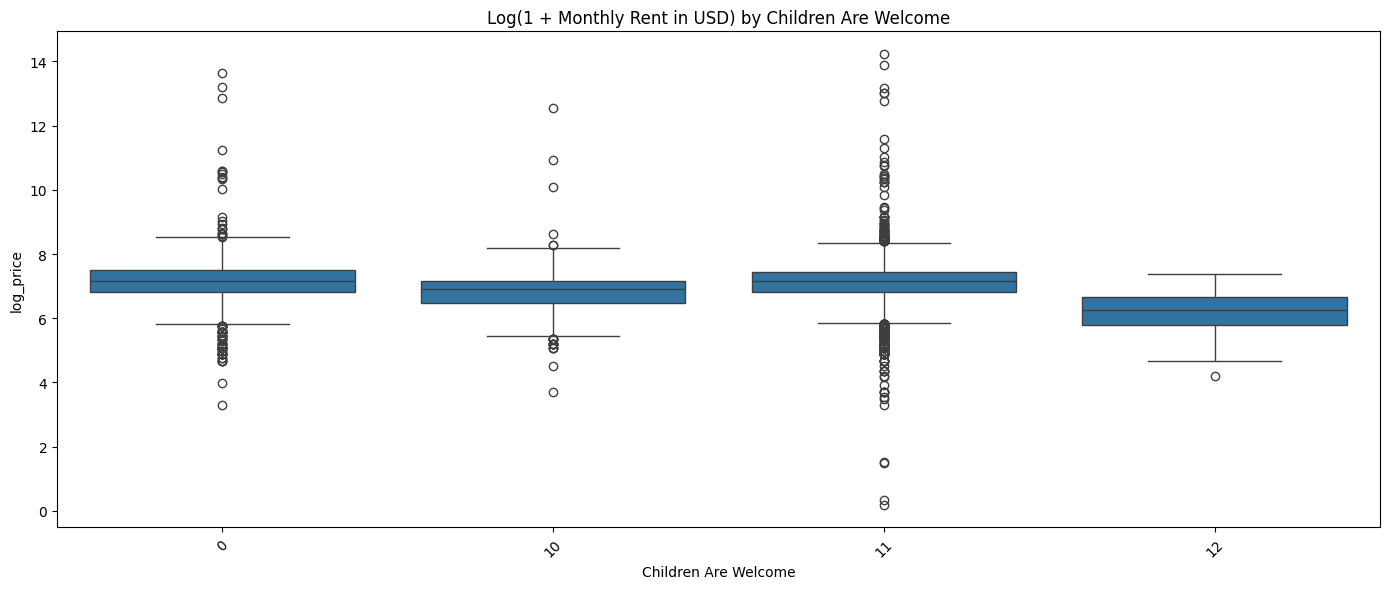

In [68]:
# children are welcome
plot_boxplot_by_category(test_df, 'children_are_welcome')

In [69]:
print_field_statistic(test_df, 'children_are_welcome')

                                     mean  median     min           max  \
children_are_welcome_cleaned                                              
0                             2613.790451  1300.0  26.000  8.500000e+05   
11                            2276.268305  1300.0   0.208  1.520833e+06   
10                            1772.133498  1000.0  39.000  2.800000e+05   
12                             621.116162   520.0  65.000  1.600000e+03   

                                       std         iqr  count  
children_are_welcome_cleaned                                   
0                             25433.293093  890.000000   1821  
11                            27321.525624  800.000000   5720  
10                            12691.825874  650.000000    505  
12                              397.806076  465.833333     99  


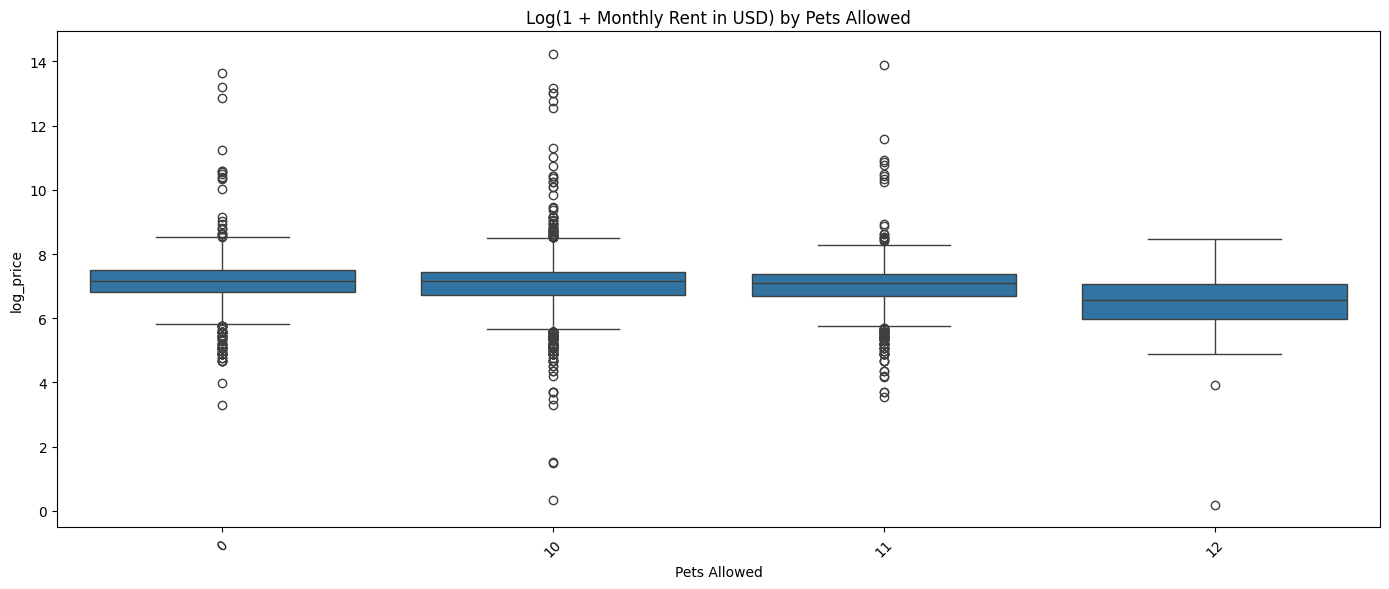

In [70]:
# pets allowed
plot_boxplot_by_category(test_df, 'pets_allowed')

In [71]:
print_field_statistic(test_df, 'pets_allowed')

                             mean       median     min           max  \
pets_allowed_cleaned                                                   
0                     2613.790451  1300.000000  26.000  8.500000e+05   
10                    2287.176799  1265.333333   0.390  1.520833e+06   
11                    2149.634434  1200.000000  33.800  1.064583e+06   
12                     856.675045   711.750000   0.208  4.745000e+03   

                               std         iqr  count  
pets_allowed_cleaned                                   
0                     25433.293093  890.000000   1821  
10                    26826.566515  868.000000   4444  
11                    26024.381341  765.666667   1703  
12                      643.091892  796.250000    177  


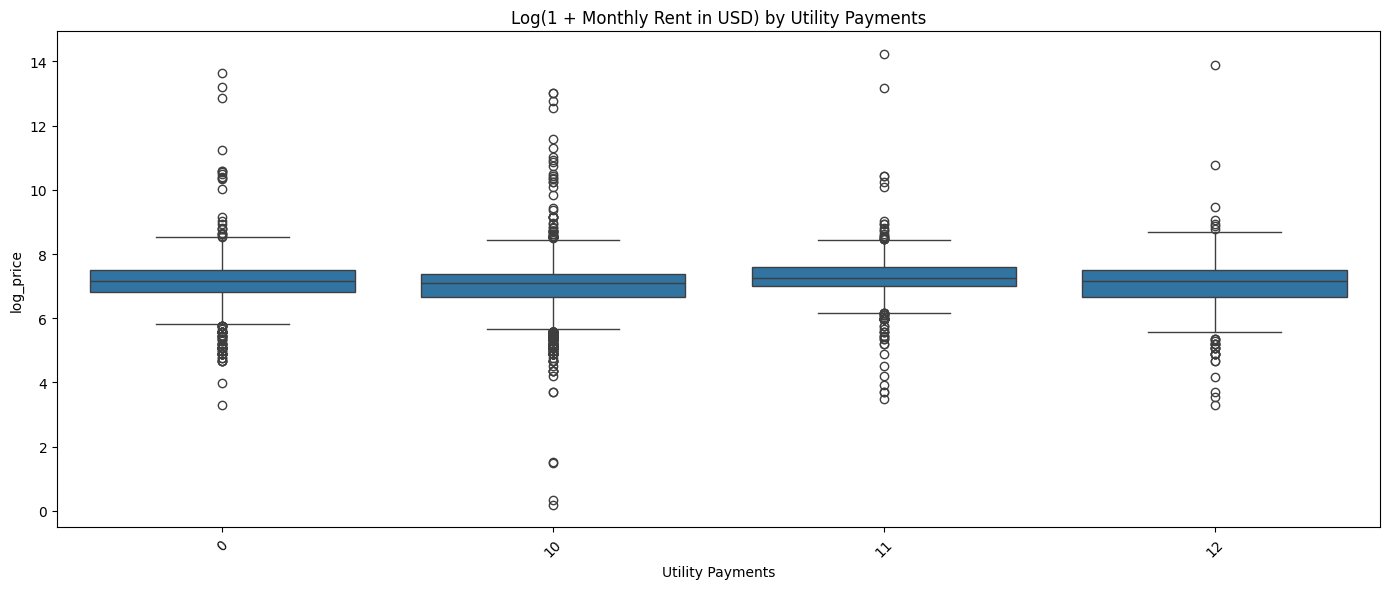

In [72]:
# Utility payments
plot_boxplot_by_category(test_df, 'utility_payments')

In [73]:
print_field_statistic(test_df, 'utility_payments')

                                 mean       median     min           max  \
utility_payments_cleaned                                                   
11                        4626.616992  1426.750000  31.200  1.520833e+06   
12                        3474.507735  1265.333333  26.000  1.064583e+06   
0                         2613.790451  1300.000000  26.000  8.500000e+05   
10                        1721.342667  1200.000000   0.208  4.500000e+05   

                                   std          iqr  count  
utility_payments_cleaned                                    
11                        59341.055058   867.520833    732  
12                        45385.479704  1038.916667    550  
0                         25433.293093   890.000000   1821  
10                        11261.304889   809.166667   5042  


In [74]:
binary_fields = ['gender', 'duration']
for col in binary_fields:
    convert_to_binary_fields(test_df, binary_fields)


--- Two-Sample T-Test for 'duration_binary' vs. log_price ---
Group 0 → Mean: 7.4811, Median: 7.3669, StDev: 0.7442, SE: 0.0196, n = 1436
Group 1 → Mean: 6.9641, Median: 7.0909, StDev: 0.7079, SE: 0.0086, n = 6709
Pooled Std Dev: 0.7144
Mean difference: 0.5170
Median difference: 0.2760
T-statistic: 24.0962
T-squared (≈ F): 580.6289
Degrees of freedom (df): 2028
95% CI for difference: (-0.5591, -0.4749)
P-value: 4.966e-113
Statistically significant? Yes (p < 0.05)


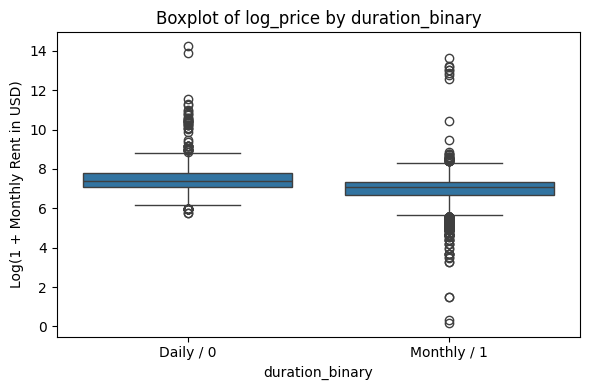

{'column': 'duration_binary',
 'mean_diff': -0.5169975230688548,
 'median_diff': -0.27595664498146544,
 't_stat': 24.09624303990589,
 't_squared': 580.628928638213,
 'df': 2028.4165902688674,
 'std0': 0.7441701298277651,
 'std1': 0.7078924040843316,
 'pooled_std': 0.7144191708740298,
 'se0': 0.01963789863409888,
 'se1': 0.008642479464731172,
 'ci': (-0.5590746849211317, -0.47492036121657794),
 'p_value': 4.9663628009776276e-113,
 'significant': True}

In [75]:
# Duration
run_ttest_and_plot(test_df, 'duration_binary')


--- Two-Sample T-Test for 'new_construction' vs. log_price ---
Group 0 → Mean: 6.8435, Median: 6.9290, StDev: 0.7695, SE: 0.0119, n = 4154
Group 1 → Mean: 7.2756, Median: 7.3139, StDev: 0.6398, SE: 0.0101, n = 3991
Pooled Std Dev: 0.7089
Mean difference: 0.4321
Median difference: 0.3849
T-statistic: -27.6006
T-squared (≈ F): 761.7908
Degrees of freedom (df): 7979
95% CI for difference: (0.4014, 0.4628)
P-value: 3.067e-160
Statistically significant? Yes (p < 0.05)


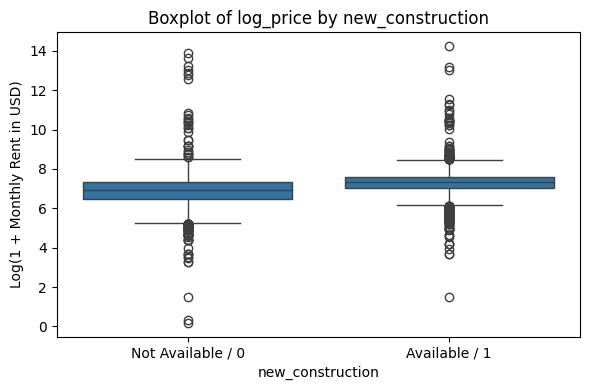

{'column': 'new_construction',
 'mean_diff': 0.43210670849307675,
 'median_diff': 0.38487966288796294,
 't_stat': -27.60055743727201,
 't_squared': 761.7907708481512,
 'df': 7979.411493888316,
 'std0': 0.7695081966418088,
 'std1': 0.6397603109720437,
 'pooled_std': 0.7089062900175958,
 'se0': 0.011939331318379022,
 'se1': 0.01012689787199954,
 'ci': (0.40141739824604483, 0.46279601874010867),
 'p_value': 3.066661114783997e-160,
 'significant': True}

In [76]:
# New Construction
run_ttest_and_plot(test_df, 'new_construction')


--- Two-Sample T-Test for 'elevator' vs. log_price ---
Group 0 → Mean: 6.7318, Median: 6.8145, StDev: 0.8177, SE: 0.0143, n = 3259
Group 1 → Mean: 7.2710, Median: 7.3139, StDev: 0.5943, SE: 0.0085, n = 4886
Pooled Std Dev: 0.6924
Mean difference: 0.5392
Median difference: 0.4993
T-statistic: -32.3697
T-squared (≈ F): 1047.8002
Degrees of freedom (df): 5503
95% CI for difference: (0.5065, 0.5718)
P-value: 1.433e-210
Statistically significant? Yes (p < 0.05)


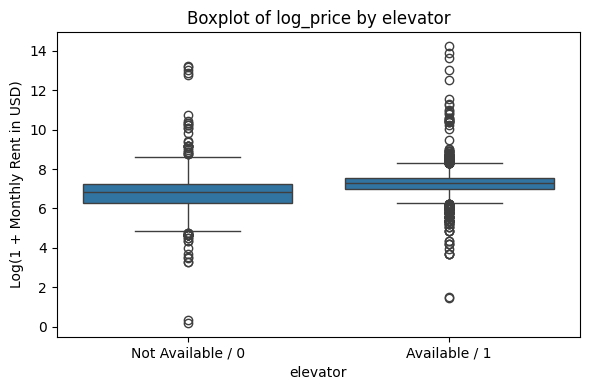

{'column': 'elevator',
 'mean_diff': 0.5391932391987186,
 'median_diff': 0.49934393437350355,
 't_stat': -32.36974221347613,
 't_squared': 1047.8002109668985,
 'df': 5502.566333018438,
 'std0': 0.817726877244495,
 'std1': 0.5943045458324985,
 'pooled_std': 0.692402071158422,
 'se0': 0.014324058705525302,
 'se1': 0.008502219656695684,
 'ci': (0.506538303910697, 0.5718481744867403),
 'p_value': 1.4328881219780882e-210,
 'significant': True}

In [77]:
# Elevator
run_ttest_and_plot(test_df, 'elevator')

In [78]:
def print_count_occurrences(df, category_prefix):
    """
    Print the frequency of different counts (e.g., number of appliances) per row.

    Args:
        df (pd.DataFrame): Your DataFrame.
        category_prefix (str): Prefix of the columns to include (e.g., 'appliances_', 'amenities_').
    """
    df = df.drop(columns=[col for col in df.columns if col.endswith('_cleaned') 
                          or col.endswith('_count') 
                          or col.endswith('_binary') 
                          or col.endswith('_wrapped')
                          or col.endswith('_not_specified')
                         ])
    # Get relevant columns
    group_cols = [col for col in df.columns if col.startswith(category_prefix)]
    print(group_cols)
    
    none_cols = [col for col in group_cols if col.endswith('_none')]
    valid_cols = [col for col in group_cols if col not in none_cols]
    print(valid_cols)

    # Ensure binary numeric values (robust)
    df_temp = df[group_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

    # Remove rows where all fields are 0 (i.e., truly missing group)
    df_temp = df_temp[df_temp.sum(axis=1) > 0]
    
    # Compute count with correct logic
    if none_cols:
        none_col = none_cols[0]
        count_series = df_temp.apply(lambda row: 0 if row[none_col] == 1 else row[valid_cols].sum(), axis=1)
    else:
        count_series = df_temp[valid_cols].sum(axis=1)

    # Print value counts
    print(f"\n▶ Occurrence of different {category_prefix[:-1]} counts:")
    print(count_series.value_counts().sort_index())


In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

def anova_categorical_column(df, column_name, target_col='log_price', min_group_size=30):
    """
    Perform ANOVA and plot for a single categorical column against target price, 
    including DF, SS, MS, CI, and mean markers.
    """
    print(f"\n--- ANOVA for {column_name} ---")

    # Drop NaNs
    temp_df = df[[column_name, target_col]].dropna()

    # Filter valid groups
    group_sizes = temp_df[column_name].value_counts()
    valid_groups = group_sizes[group_sizes >= min_group_size].index
    temp_df = temp_df[temp_df[column_name].isin(valid_groups)]

    if temp_df[column_name].nunique() < 2:
        print("Not enough groups with sufficient samples.")
        return

    # Prepare groups
    grouped = temp_df.groupby(column_name)[target_col]
    groups = [group for _, group in grouped]

    # Run ANOVA
    stat, p_value = f_oneway(*groups)
    print(f"F-statistic: {stat:.4f}")
    print(f"P-value:    {p_value:.4g}")
    print("→ Significant differences." if p_value < 0.05 else "→ No significant differences.")

    # ANOVA Table values
    k = len(groups)                   # number of groups
    N = len(temp_df)                 # total observations
    grand_mean = temp_df[target_col].mean()

    ss_between = sum(g.size * (g.mean() - grand_mean)**2 for g in groups)
    ss_within = sum(((g - g.mean())**2).sum() for g in groups)
    df_between = k - 1
    df_within = N - k
    ms_between = ss_between / df_between
    ms_within = ss_within / df_within
    f_check = ms_between / ms_within

    print("\nANOVA Table Summary:")
    print(f"{'Source':<10} {'DF':>10} {'SS':>20} {'MS':>20}")
    print(f"{'Between':<10} {df_between:>10,} {ss_between:>20,.2f} {ms_between:>20,.2f}")
    print(f"{'Within':<10} {df_within:>10,} {ss_within:>20,.2f} {ms_within:>20,.2f}")
    print(f"{'Total':<10} {N-1:>10,} {(ss_between + ss_within):>20,.2f}")

    # Boxplot with red dot for mean
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=temp_df, x=column_name, y=target_col, showfliers=True)
    means = grouped.mean()
    plt.scatter(x=range(len(means)), y=means.values, color='red', zorder=10, label='Mean')
    plt.title(f"{target_col} vs {column_name}")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Log(1 + Monthly Rent in USD)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # CI Plot
    stats_df = grouped.agg(['mean', 'count', 'std'])
    stats_df['se'] = stats_df['std'] / np.sqrt(stats_df['count'])
    stats_df['ci95'] = 1.96 * stats_df['se']

    plt.figure(figsize=(10, 5))
    plt.errorbar(x=stats_df.index, y=stats_df['mean'], yerr=stats_df['ci95'],
                 fmt='o', color='red', ecolor='black', capsize=5)
    plt.title(f"95% CI for Mean {target_col} by {column_name}")
    plt.xlabel(column_name)
    plt.ylabel(f"Mean Log(1 + Monthly Rent in USD)")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return stats_df.reset_index()



--- ANOVA for balcony ---
F-statistic: 167.4302
P-value:    2.524e-105
→ Significant differences.

ANOVA Table Summary:
Source             DF                   SS                   MS
Between             3               259.92                86.64
Within          8,140             4,212.23                 0.52
Total           8,143             4,472.15


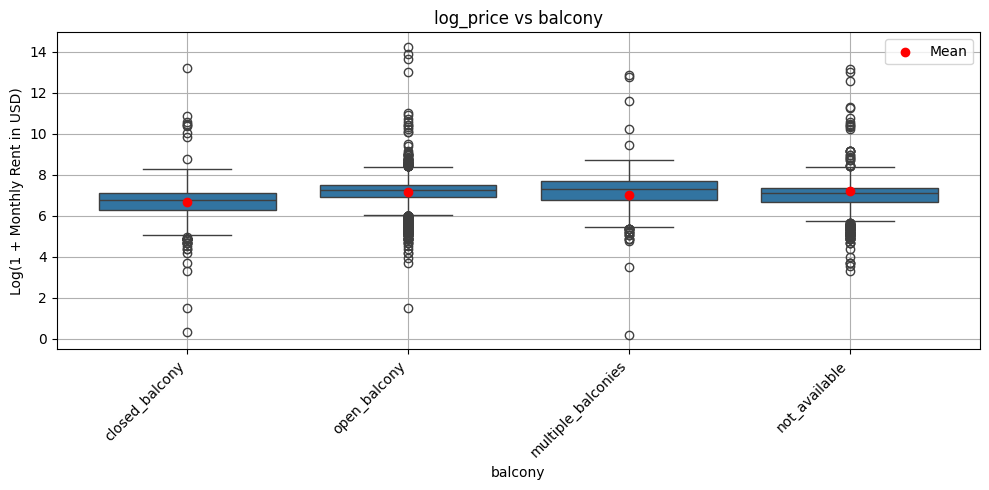

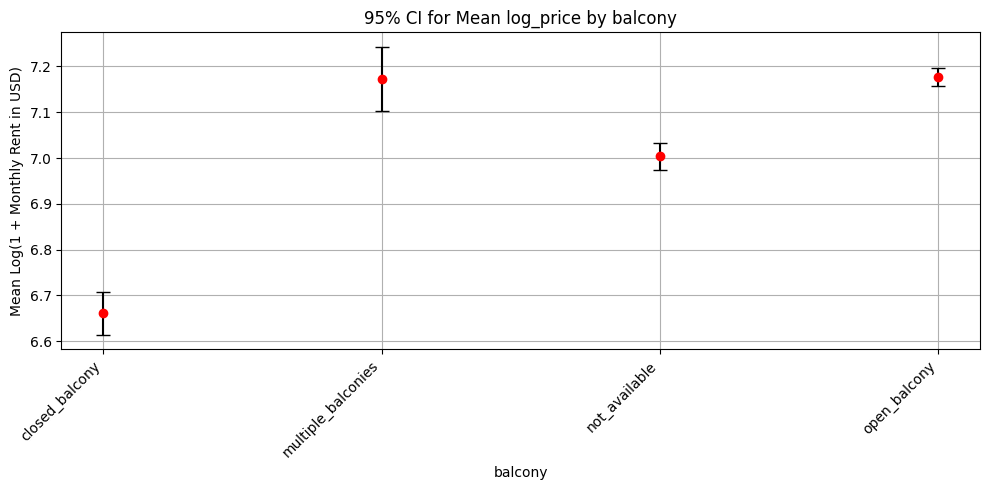

,balcony,mean,count,std,se,ci95
0,closed_balcony,6.660794,1181,0.821591,0.023907,0.046858
1,multiple_balconies,7.173325,643,0.902006,0.035572,0.069720
2,not_available,7.004181,2207,0.710388,0.015121,0.029638
3,open_balcony,7.177475,4113,0.657957,0.010259,0.020108


In [80]:
# Balcony
anova_categorical_column(test_df, 'balcony')


--- ANOVA for furniture ---
F-statistic: 41.7435
P-value:    9.197e-19
→ Significant differences.

ANOVA Table Summary:
Source             DF                   SS                   MS
Between             2                44.81                22.40
Within          8,115             4,355.51                 0.54
Total           8,117             4,400.32


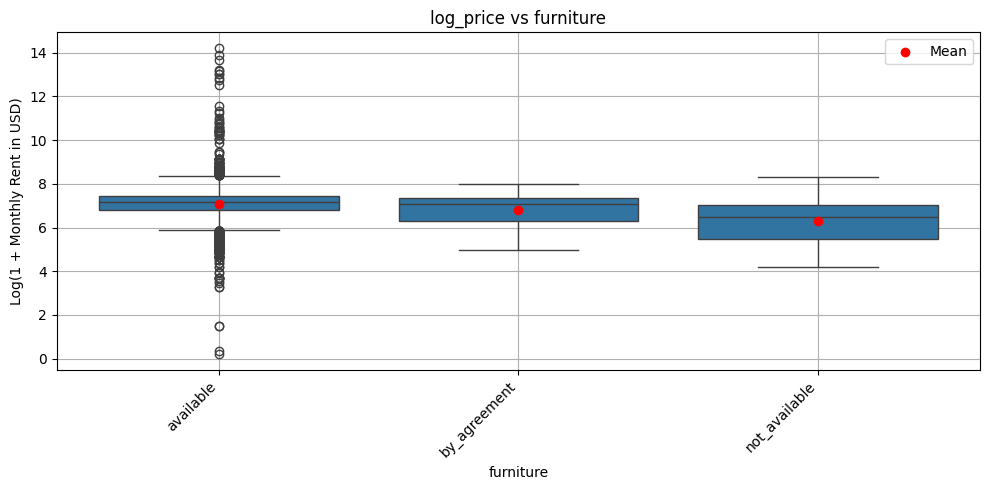

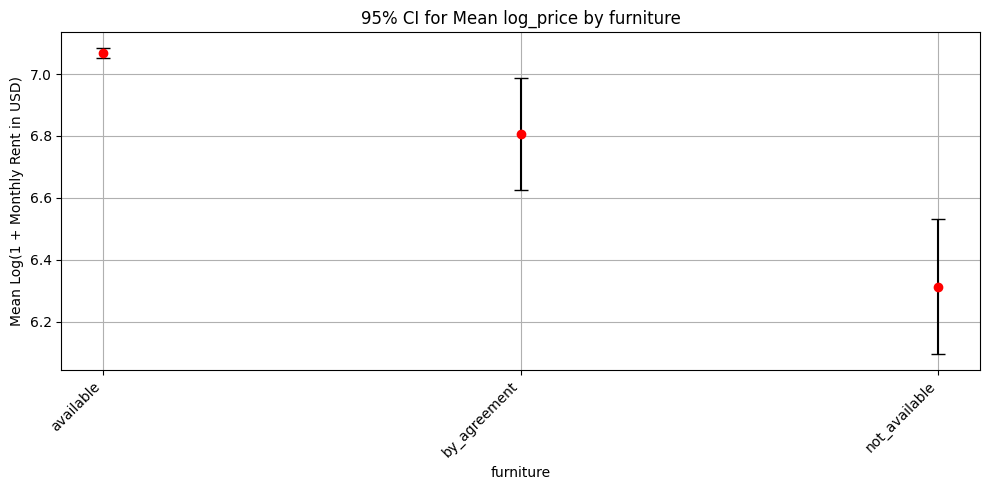

,furniture,mean,count,std,se,ci95
0,available,7.069298,7976,0.730099,0.008175,0.016023
1,by_agreement,6.806993,71,0.777593,0.092283,0.180875
2,not_available,6.313400,71,0.942265,0.111826,0.219180


In [81]:
# Furniture
anova_categorical_column(test_df, 'furniture')


--- ANOVA for renovation ---
F-statistic: 439.1540
P-value:    0
→ Significant differences.

ANOVA Table Summary:
Source             DF                   SS                   MS
Between             5               940.52               188.10
Within          8,126             3,480.65                 0.43
Total           8,131             4,421.17


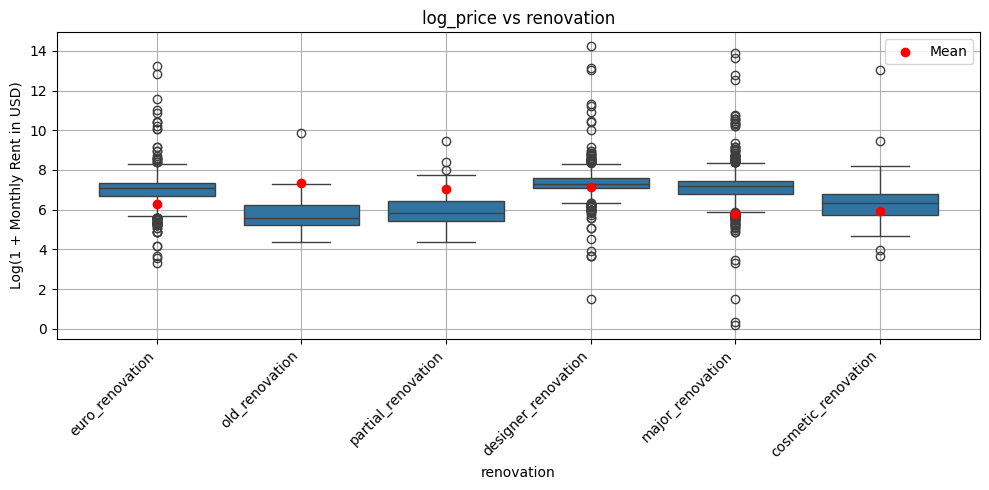

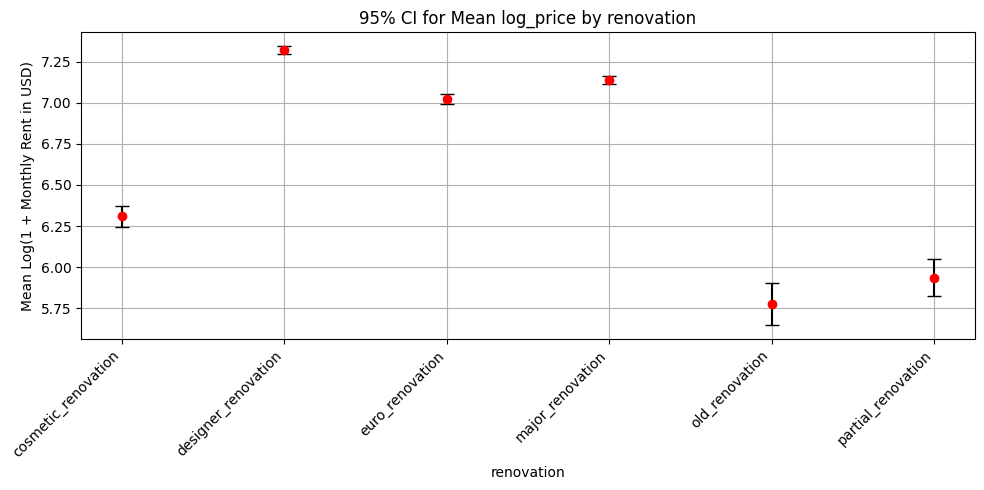

,renovation,mean,count,std,se,ci95
0,cosmetic_renovation,6.308594,552,0.783097,0.033331,0.065328
1,designer_renovation,7.320458,2353,0.557577,0.011495,0.022529
2,euro_renovation,7.023049,2001,0.665234,0.014871,0.029148
3,major_renovation,7.140394,2914,0.680279,0.012602,0.024700
4,old_renovation,5.777812,141,0.778095,0.065527,0.128434
5,partial_renovation,5.936381,171,0.742108,0.056750,0.111231


In [82]:
# Renovation
anova_categorical_column(test_df, 'renovation')


--- ANOVA for construction_type ---
F-statistic: 343.6675
P-value:    4.021e-210
→ Significant differences.

ANOVA Table Summary:
Source             DF                   SS                   MS
Between             3               501.04               167.01
Within          8,129             3,950.46                 0.49
Total           8,132             4,451.49


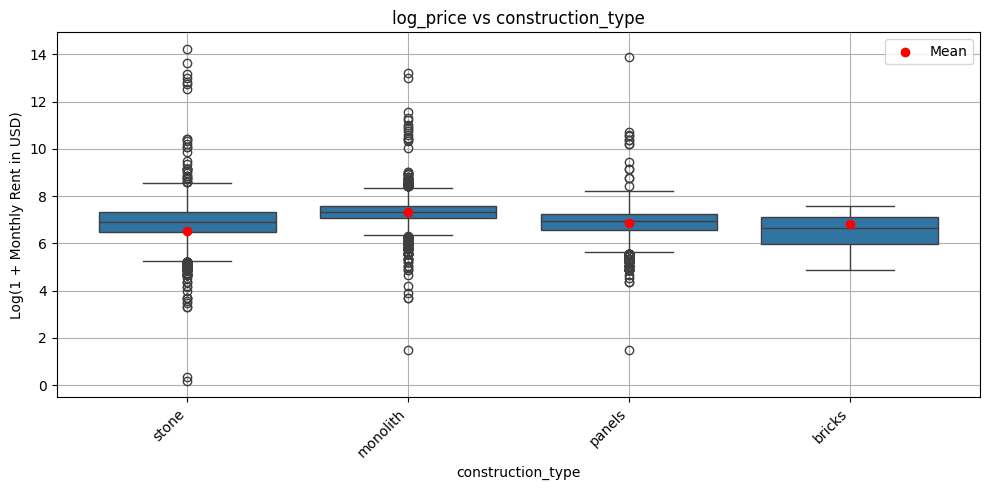

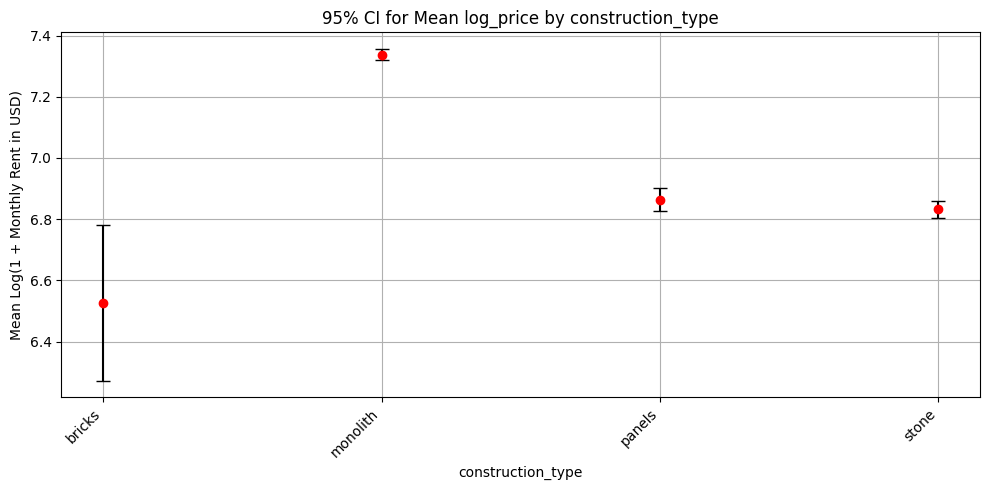

,construction_type,mean,count,std,se,ci95
0,bricks,6.526175,31,0.722911,0.129839,0.254484
1,monolith,7.337941,3531,0.559656,0.009418,0.018460
2,panels,6.863459,1382,0.720350,0.019377,0.037979
3,stone,6.831714,3189,0.814032,0.014415,0.028253


In [83]:
# Construction_type
anova_categorical_column(test_df, 'construction_type')


--- ANOVA for children_are_welcome ---
F-statistic: 64.1830
P-value:    5.208e-41
→ Significant differences.

ANOVA Table Summary:
Source             DF                   SS                   MS
Between             3               103.33                34.44
Within          8,141             4,368.96                 0.54
Total           8,144             4,472.30


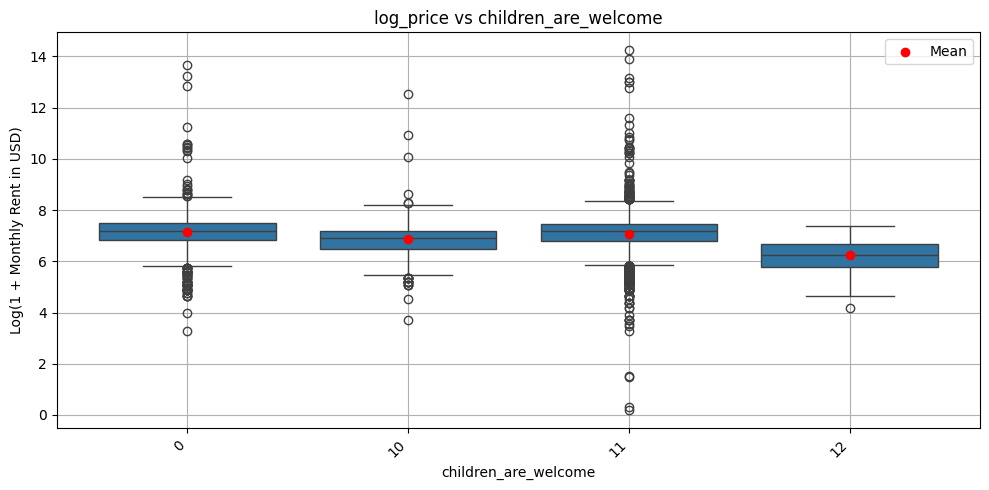

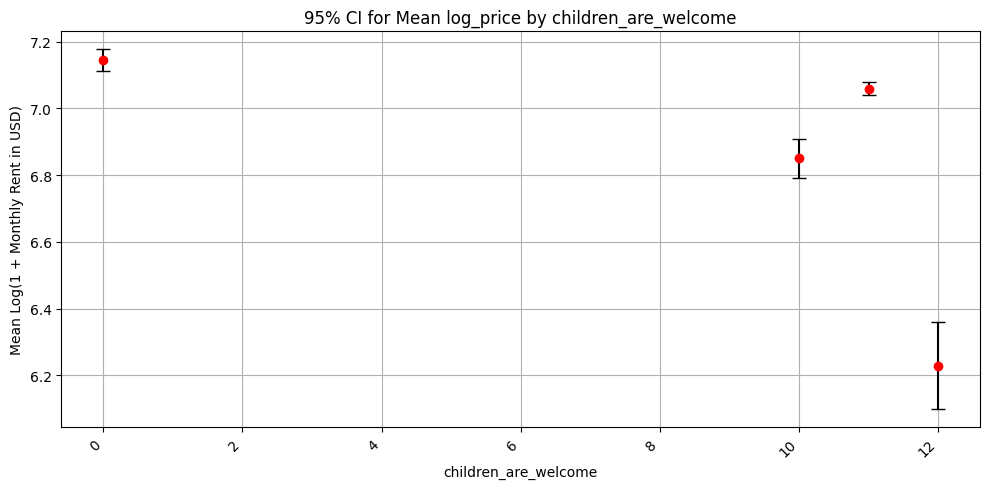

,children_are_welcome,mean,count,std,se,ci95
0,0,7.144530,1821,0.710014,0.016638,0.032611
1,10,6.850510,505,0.677852,0.030164,0.059121
2,11,7.059147,5720,0.745279,0.009854,0.019314
3,12,6.229141,99,0.664847,0.066820,0.130967


In [84]:
# Children welcome
anova_categorical_column(test_df, 'children_are_welcome')


--- ANOVA for pets_allowed ---
F-statistic: 49.7669
P-value:    7.268e-32
→ Significant differences.

ANOVA Table Summary:
Source             DF                   SS                   MS
Between             3                80.54                26.85
Within          8,141             4,391.76                 0.54
Total           8,144             4,472.30


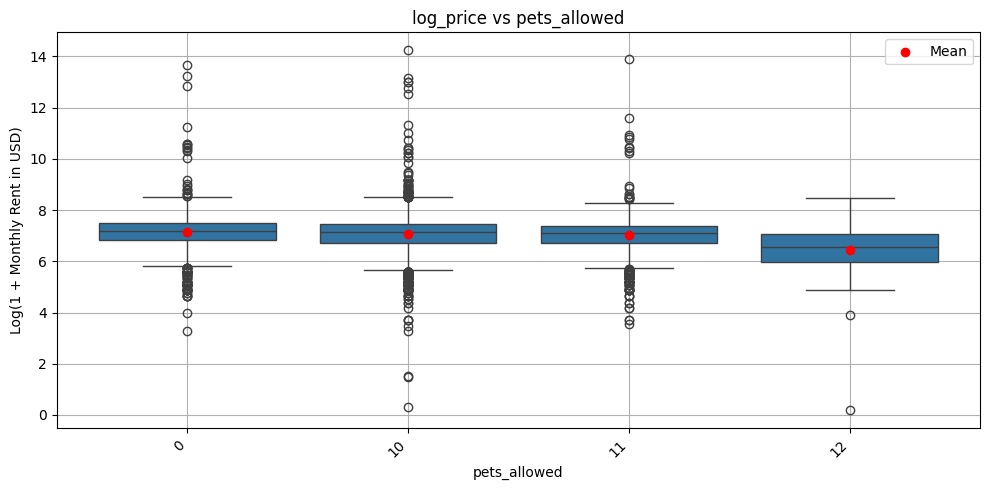

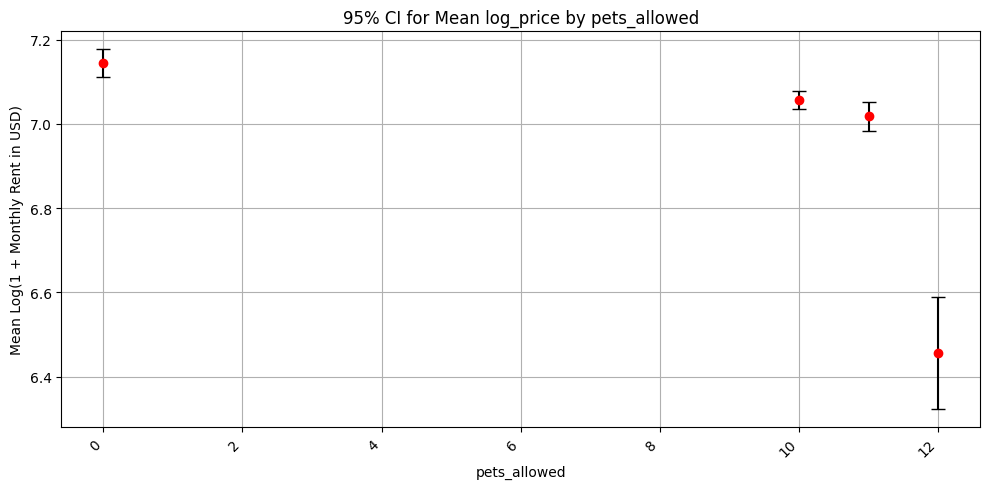

,pets_allowed,mean,count,std,se,ci95
0,0,7.144530,1821,0.710014,0.016638,0.032611
1,10,7.056619,4444,0.741664,0.011126,0.021806
2,11,7.018383,1703,0.721850,0.017492,0.034284
3,12,6.455325,177,0.902832,0.067861,0.133008


In [85]:
# Pets allowed
anova_categorical_column(test_df, 'pets_allowed')


--- ANOVA for utility_payments ---
F-statistic: 43.4135
P-value:    7.975e-28
→ Significant differences.

ANOVA Table Summary:
Source             DF                   SS                   MS
Between             3                70.42                23.47
Within          8,141             4,401.88                 0.54
Total           8,144             4,472.30


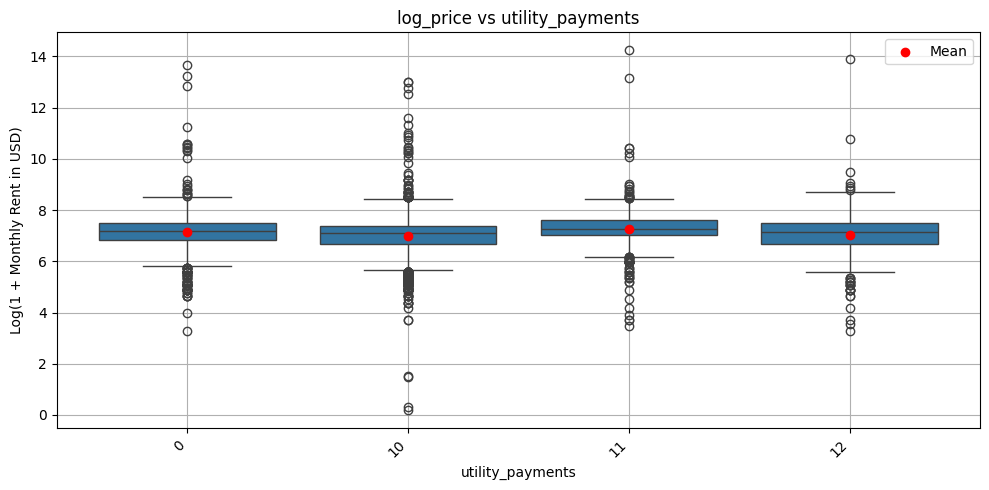

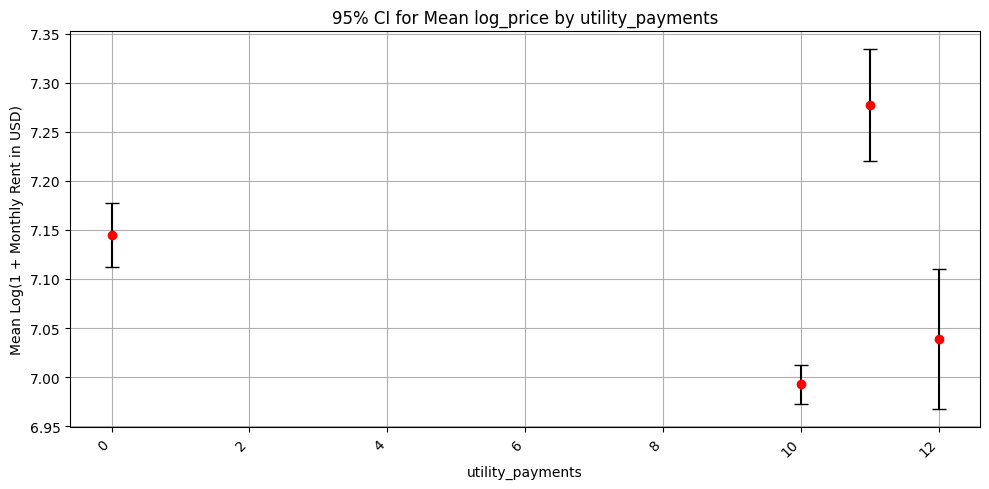

,utility_payments,mean,count,std,se,ci95
0,0,7.144530,1821,0.710014,0.016638,0.032611
1,10,6.992552,5042,0.721953,0.010167,0.019928
2,11,7.276832,732,0.787462,0.029105,0.057047
3,12,7.038957,550,0.857449,0.036562,0.071661


In [86]:
# Utilities payments
anova_categorical_column(test_df, 'utility_payments')


--- ANOVA for number_of_rooms ---
F-statistic: 144.1197
P-value:    3.218e-119
→ Significant differences.

ANOVA Table Summary:
Source             DF                   SS                   MS
Between             4               292.49                73.12
Within          8,094             4,106.67                 0.51
Total           8,098             4,399.16


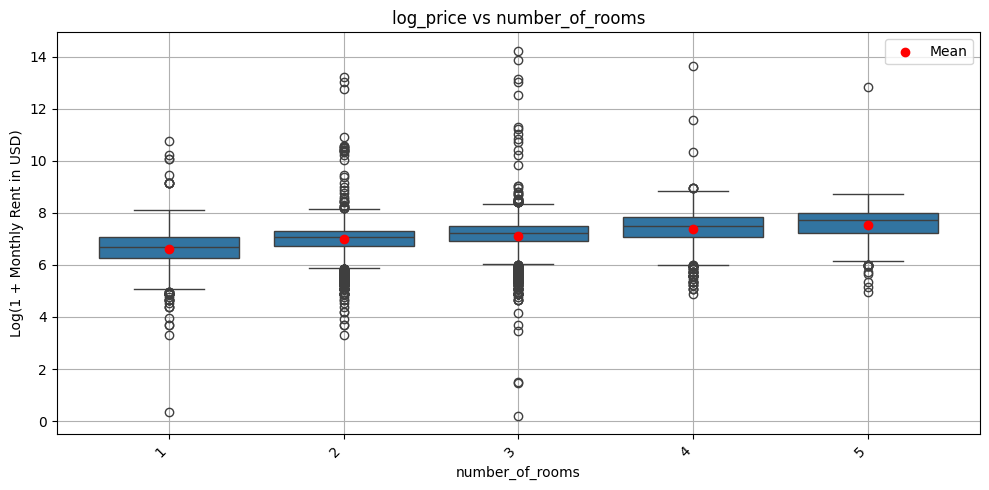

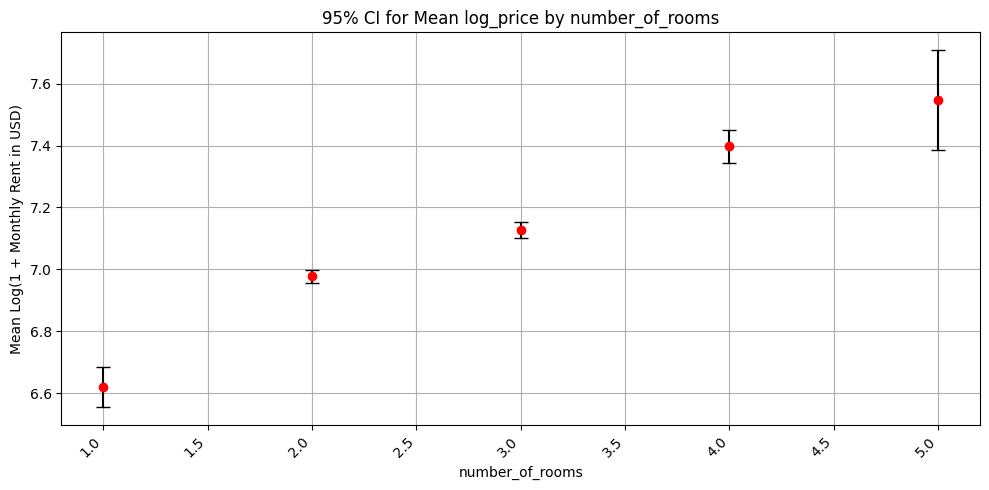

,number_of_rooms,mean,count,std,se,ci95
0,1,6.618972,703,0.869901,0.032809,0.064306
1,2,6.977196,3495,0.640908,0.010841,0.021248
2,3,7.128438,2999,0.729500,0.013321,0.026109
3,4,7.397111,774,0.750784,0.026986,0.052893
4,5,7.547361,128,0.926747,0.081914,0.160551


In [87]:
# Number of rooms
anova_categorical_column(test_df, 'number_of_rooms')


--- ANOVA for number_of_bathrooms ---
F-statistic: 442.8305
P-value:    2.751e-183
→ Significant differences.

ANOVA Table Summary:
Source             DF                   SS                   MS
Between             2               438.76               219.38
Within          8,142             4,033.54                 0.50
Total           8,144             4,472.30


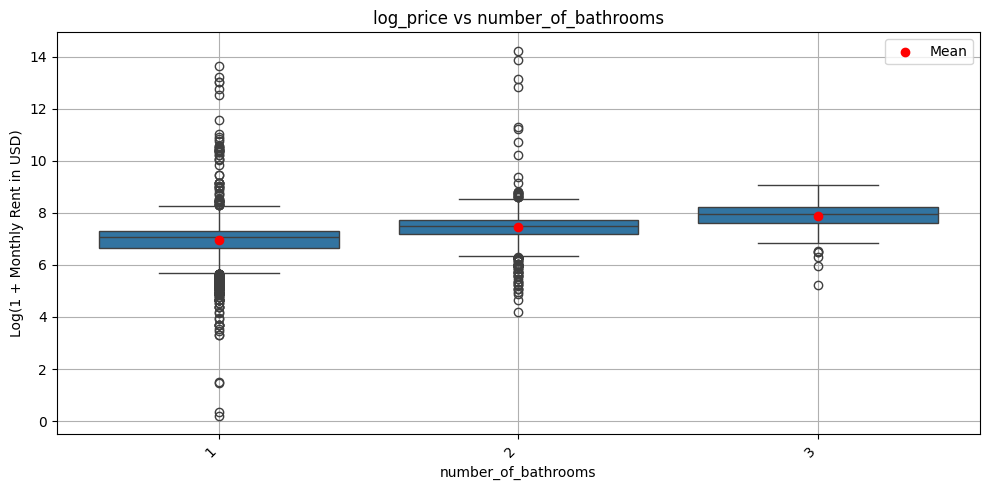

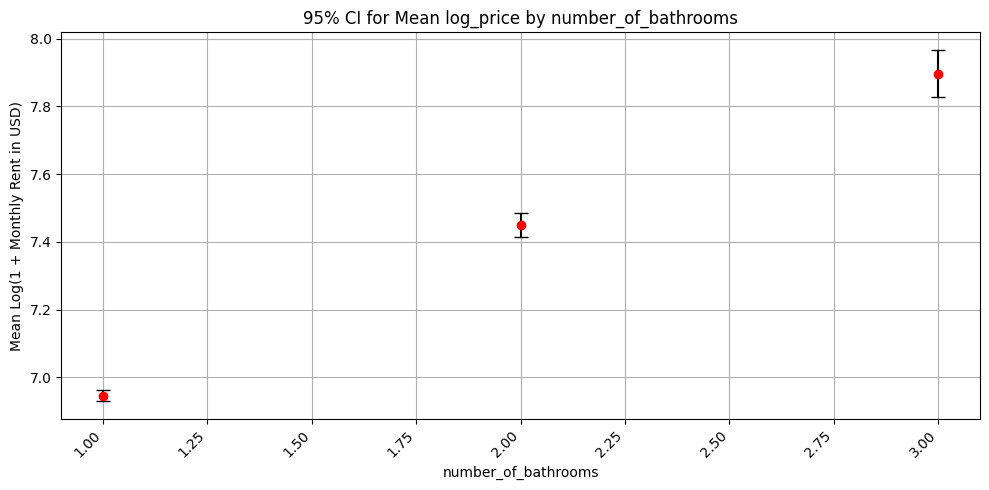

,number_of_bathrooms,mean,count,std,se,ci95
0,1,6.946568,6573,0.715604,0.008827,0.01730
1,2,7.449104,1360,0.670395,0.018179,0.03563
2,3,7.896838,212,0.521195,0.035796,0.07016


In [88]:
# Number of bathrooms
anova_categorical_column(test_df, 'number_of_bathrooms')


--- ANOVA for floor ---
F-statistic: 44.7006
P-value:    1.214e-135
→ Significant differences.

ANOVA Table Summary:
Source             DF                   SS                   MS
Between            16               361.63                22.60
Within          8,119             4,105.18                 0.51
Total           8,135             4,466.81


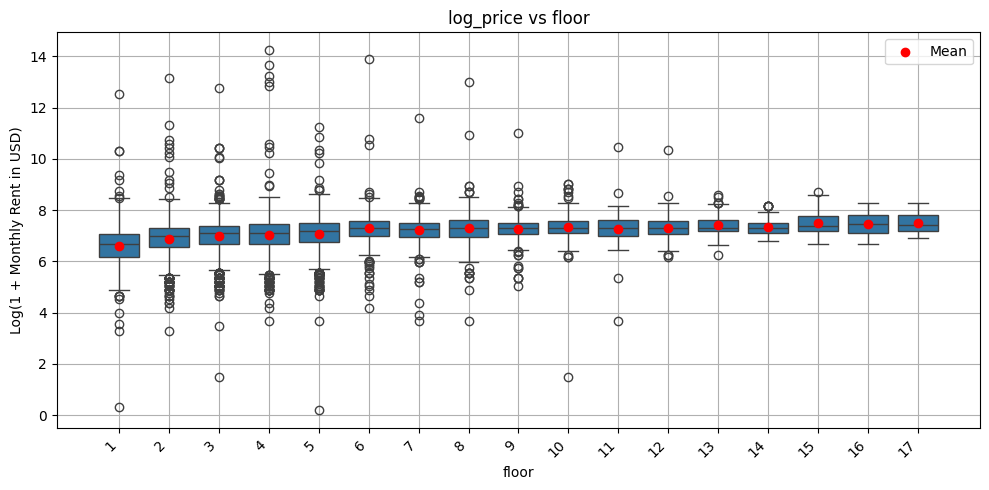

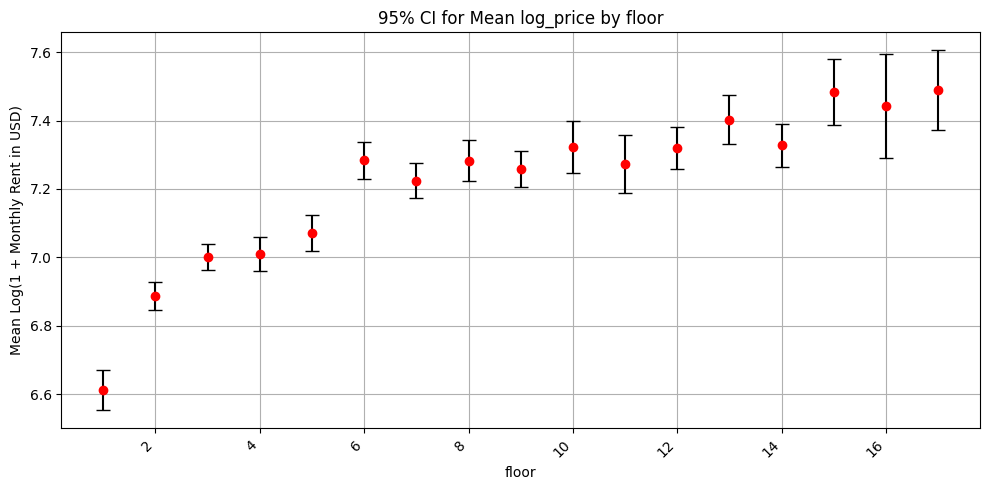

,floor,mean,count,std,se,ci95
0,1,6.610794,759,0.820176,0.029771,0.058350
1,2,6.886772,1327,0.741898,0.020366,0.039918
2,3,7.000496,1310,0.723414,0.019987,0.039175
3,4,7.009930,1099,0.840241,0.025346,0.049678
4,5,7.070390,845,0.781751,0.026893,0.052710
5,6,7.283066,532,0.642830,0.027870,0.054626
6,7,7.223744,466,0.569604,0.026386,0.051717
7,8,7.282714,453,0.646103,0.030357,0.059499
8,9,7.257997,342,0.507562,0.027446,0.053794
9,10,7.322467,248,0.601660,0.038205,0.074883


In [89]:
# Number of floors
anova_categorical_column(test_df, 'floor')


--- ANOVA for elevator ---
F-statistic: 1185.5473
P-value:    1.135e-242
→ Significant differences.

ANOVA Table Summary:
Source             DF                   SS                   MS
Between             1               568.38               568.38
Within          8,143             3,903.92                 0.48
Total           8,144             4,472.30


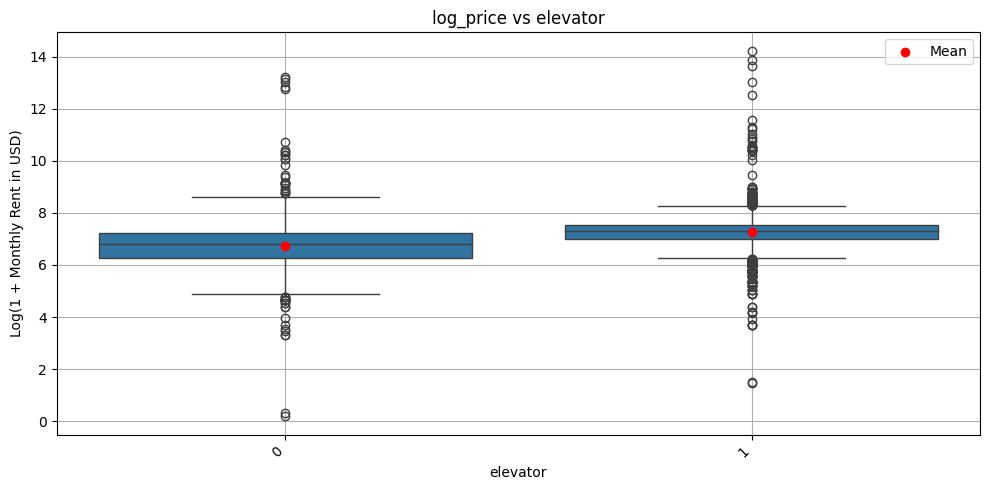

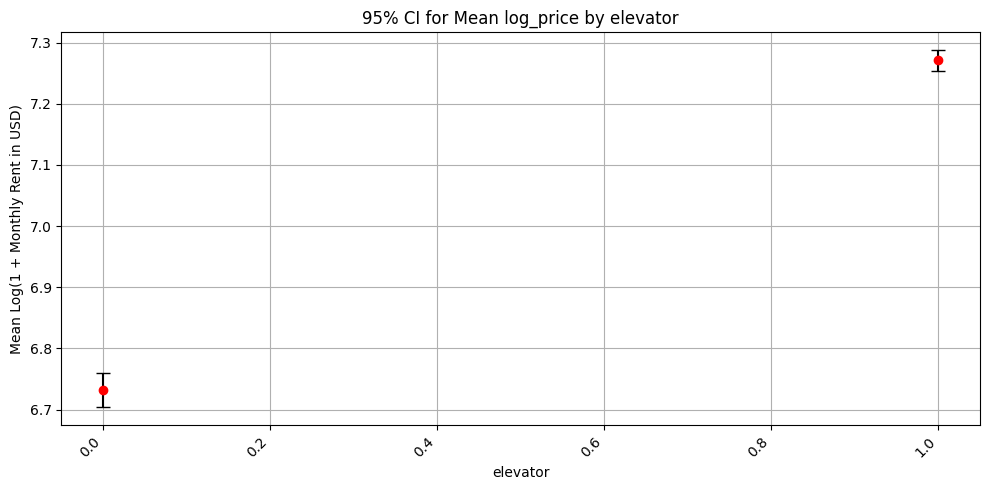

,elevator,mean,count,std,se,ci95
0,0,6.731762,3259,0.817727,0.014324,0.028075
1,1,7.270956,4886,0.594305,0.008502,0.016664


In [90]:
# elevator
anova_categorical_column(test_df, 'elevator')

In [91]:
# Encode duration 
test_df['duration_encoded'] = test_df['duration'].map({'daily': 0, 'monthly': 1})

In [92]:
show_unique_values(test_df, 'construction_type')

Unique values in 'construction_type':
{'bricks', 'panels', 'stone', 'monolith', 'cassette', 'wooden'}


In [93]:
def print_missing_values(df):
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if missing.empty:
        print("✅ No missing values found.")
    else:
        print("🔍 Missing values per column:")
        for col, count in missing.items():
            print(f"{col}: {count}")

In [94]:
print_missing_values(test_df)

🔍 Missing values per column:
floor_area: 1
balcony: 1


In [95]:
test_df['ceiling_height'].dtype

dtype('float64')

In [96]:
show_unique_values(test_df, 'balcony')

Unique values in 'balcony':
{'closed_balcony', 'open_balcony', 'multiple_balconies', 'not_available'}


In [97]:
show_unique_values(test_df, 'construction_type')

Unique values in 'construction_type':
{'bricks', 'panels', 'stone', 'monolith', 'cassette', 'wooden'}


In [98]:
show_unique_values(test_df, 'furniture')

Unique values in 'furniture':
{'not_available', 'by_agreement', 'partial_furniture', 'available'}


In [99]:
show_unique_values(test_df, 'renovation')

Unique values in 'renovation':
{'partial_renovation', 'euro_renovation', 'cosmetic_renovation', 'old_renovation', 'major_renovation', 'designer_renovation', 'no_renovation'}


In [100]:
print(test_df.columns.tolist())

['reg_id', 'gender', 'age', 'construction_type', 'new_construction', 'elevator', 'floors_in_the_building', 'floor_area', 'number_of_rooms', 'number_of_bathrooms', 'ceiling_height', 'floor', 'balcony', 'furniture', 'renovation', 'children_are_welcome', 'pets_allowed', 'utility_payments', 'address', 'price', 'currency', 'duration', 'datetime', 'amenities', 'appliances', 'parking', 'monthly_price', 'exchange_rate', 'monthly_price_usd', 'log_price', 'gender_binary', 'duration_binary', 'duration_encoded']


In [101]:
def clean_task_1c_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = df.columns.str.strip()

    # removes whitespace
    df.columns = df.columns.str.lower()
    
    # Drop unnecessary columns
    drop_columns = [
        'reg_id', 'age', 'gender', 'price', 'currency', 'datetime',
        'monthly_price', 'exchange_rate',
        'gender_binary', 'duration', 'duration_binary'
    ]
    df = df.drop(columns=[col for col in drop_columns if col in df.columns], errors='ignore')

    # Drop rows with NaN in specified critical fields
    critical_nan_fields = [
        'elevator', 'new_construction', 'floor_area', 'number_of_bathrooms', 'construction_type',
        'ceiling_height', 'balcony', 'renovation'
    ]
    df = df.dropna(subset=critical_nan_fields)

    # Impute missing values with mode for specified fields
    impute_fields = ['pets_allowed', 'children_are_welcome', 'utility_payments']
    for field in impute_fields:
        if df[field].isnull().sum() > 0:
            mode_value = df[field].mode().iloc[0]
            print(mode_value)
            df[field] = df[field].fillna(mode_value)

    # Encode categorical features
    categorical_mappings = {
        'construction_type': {'stone': 0, 'cassette': 1, 'panels': 2, 'monolith': 3, 'bricks': 4, 'wooden':5},
        'balcony': {'not_available': 0, 'closed_balcony': 1, 'open_balcony': 2, 'multiple_balconies': 3},
        'furniture': {'not_available': 0, 'partial_furniture': 1, 'by_agreement': 2, 'available': 3},
        'renovation': {
            'no_renovation': 0, 'partial_renovation': 1, 'old_renovation': 2,
            'cosmetic_renovation': 3, 'euro_renovation': 4, 'major_renovation': 5,
            'designer_renovation': 6
        }
    }
    for col, mapping in categorical_mappings.items():
        if col in df.columns:
            df[f'{col}_encoded'] = df[col].map(mapping)
            df = df.drop(columns=[col])

    # Ensure proper types
    int_columns = [
        'construction_type_encoded', 'new_construction', 'elevator',
        'floor_in_the_building', 'floor_area', 'number_of_rooms',
        'number_of_bathrooms', 'floor'
    ]
    for col in int_columns:
        if col in df.columns:
            print(col)
            df[col] = df[col].astype(int)

    return df


In [102]:
test_df_cleaned = clean_task_1c_data(test_df)

construction_type_encoded
new_construction
elevator
floor_area
number_of_rooms
number_of_bathrooms
floor


In [103]:
# Export cleaned DataFrame to CSV
test_df_cleaned.to_csv('test_data_1c_before_address.csv', index=False, encoding='utf-8-sig')

In [115]:
address_df = test_df_cleaned.copy()

In [110]:
from deep_translator import GoogleTranslator

import re

def contains_armenian(text):
    return bool(re.search(r'[\u0530-\u058F]', text))

def contains_russian(text):
    # Cyrillic Unicode range: \u0400–\u04FF
    return bool(re.search(r'[\u0400-\u04FF]', str(text)))

import pandas as pd
import re

def count_armenian_addresses(df, address_col='address'):
    # Armenian Unicode range: \u0530–\u058F
    pattern = re.compile(r'[\u0530-\u058F]')
    count = df[address_col].apply(lambda x: bool(pattern.search(str(x)))).sum()
    return count

import re

def count_russian_addresses(df, address_col='address'):
    # Russian/Cyrillic Unicode range: \u0400–\u04FF
    pattern = re.compile(r'[\u0400-\u04FF]')
    count = df[address_col].apply(lambda x: bool(pattern.search(str(x)))).sum()
    return count

from deep_translator import MyMemoryTranslator
from translate import Translator

import time

def translate_address(text):
    try:
        return GoogleTranslator(source='auto', target='en').translate(text)
    except Exception:
        print(f"Translation failed for: {text}.")
        return text

def translate_armenian_addresses(df, address_col='address'):
    df = df.copy()
    translated = []
    for i, addr in enumerate(df[address_col]):
        if contains_armenian(addr):
            translated_text = translate_address(addr)
            time.sleep(1)  # avoid being blocked
        else:
            translated_text = addr

        translated.append(translated_text)

        if i % 100 == 0:
            print(f"Translated {i}/{len(df)}")
    df[address_col + '_translated'] = translated
    return df

def translate_russian_addresses(df, address_col='address'):
    df = df.copy()
    translated = []

    for i, addr in enumerate(df[address_col]):
        if contains_russian(addr):
            translated_text = translate_address(addr)
            time.sleep(1)  # delay to avoid being rate-limited
        else:
            translated_text = addr

        translated.append(translated_text)

        if i % 100 == 0:
            print(f"Translated {i}/{len(df)}")

    df[address_col + '_translated'] = translated
    return df

In [116]:
armenian_count = count_armenian_addresses(address_df)
print(f"Number of addresses with Armenian characters: {armenian_count}")

Number of addresses with Armenian characters: 965


In [112]:
# test_df = address_df.head(200)

In [117]:
address_df = translate_armenian_addresses(address_df, address_col='address')

Translated 0/8143
Translated 100/8143
Translated 200/8143
Translated 300/8143
Translated 400/8143
Translated 500/8143
Translated 600/8143
Translated 700/8143
Translated 800/8143
Translated 900/8143
Translated 1000/8143
Translated 1100/8143
Translated 1200/8143
Translated 1300/8143
Translated 1400/8143
Translated 1500/8143
Translated 1600/8143
Translated 1700/8143
Translated 1800/8143
Translated 1900/8143
Translated 2000/8143
Translated 2100/8143
Translated 2200/8143
Translated 2300/8143
Translated 2400/8143
Translated 2500/8143
Translated 2600/8143
Translated 2700/8143
Translated 2800/8143
Translated 2900/8143
Translated 3000/8143
Translated 3100/8143
Translated 3200/8143
Translated 3300/8143
Translated 3400/8143
Translated 3500/8143
Translated 3600/8143
Translated 3700/8143
Translated 3800/8143
Translated 3900/8143
Translated 4000/8143
Translated 4100/8143
Translated 4200/8143
Translated 4300/8143
Translated 4400/8143
Translated 4500/8143
Translated 4600/8143
Translated 4700/8143
Tran

In [118]:
address_df

,new_construction,elevator,floors_in_the_building,floor_area,number_of_rooms,number_of_bathrooms,ceiling_height,floor,children_are_welcome,pets_allowed,...,appliances,parking,monthly_price_usd,log_price,duration_encoded,construction_type_encoded,balcony_encoded,furniture_encoded,renovation_encoded,address_translated
0,0,0,5,60,2,1,2.75,4,10,10,...,none,none,1118.000000,7.020191,1,0,1,3,4,"Papazyan, st"
1,0,0,5,82,4,1,2.75,5,0,0,...,none,none,728.000000,6.591674,1,0,2,3,2,Yerevan › Arabkir
2,0,0,4,54,2,1,2.70,4,11,10,...,none,none,130.000000,4.875197,1,0,1,3,1,Aragatsotn › Aparan
3,0,0,4,73,2,1,2.70,3,11,10,...,none,none,156.000000,5.056246,1,0,3,3,6,Aragatsotn › Aparan
4,0,0,5,72,3,1,3.00,1,11,10,...,none,none,1265.333333,7.143881,0,0,1,3,5,"Tigran Mets street 46, Tower"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8142,1,1,11,85,3,1,3.00,8,0,0,...,none,none,2000.000000,7.601402,1,3,0,3,5,"Amiryan Street, Yerevan"
8143,1,1,9,130,4,2,3.00,4,11,10,...,none,none,2600.000000,7.863651,1,3,0,3,5,"Nikoghayos Adonts Street, Yerevan"
8144,0,1,4,170,8,2,3.00,3,0,0,...,none,none,2990.000000,8.003363,1,0,2,3,5,"Teryan street, Yerevan"
8145,0,1,9,51,2,1,2.80,3,11,10,...,none,none,1977.083333,7.589884,0,2,0,3,5,"Amiryan Street, Yerevan"


In [120]:
armenian_count = count_armenian_addresses(address_df, 'address_translated')
print(f"Number of addresses with Armenian characters: {armenian_count}")

Number of addresses with Armenian characters: 6


In [121]:
# Export translated DataFrame to CSV
address_df.to_csv('test_address_translated.csv', index=False, encoding='utf-8-sig')

In [122]:
count_russian_addresses(address_df, 'address_translated')

208

In [123]:
address_df1 = translate_russian_addresses(address_df, address_col='address_translated')

Translated 0/8143
Translated 100/8143
Translated 200/8143
Translated 300/8143
Translated 400/8143
Translated 500/8143
Translated 600/8143
Translated 700/8143
Translated 800/8143
Translated 900/8143
Translated 1000/8143
Translated 1100/8143
Translated 1200/8143
Translated 1300/8143
Translated 1400/8143
Translated 1500/8143
Translated 1600/8143
Translated 1700/8143
Translated 1800/8143
Translated 1900/8143
Translated 2000/8143
Translated 2100/8143
Translated 2200/8143
Translated 2300/8143
Translated 2400/8143
Translated 2500/8143
Translated 2600/8143
Translated 2700/8143
Translated 2800/8143
Translated 2900/8143
Translated 3000/8143
Translated 3100/8143
Translated 3200/8143
Translated 3300/8143
Translated 3400/8143
Translated 3500/8143
Translated 3600/8143
Translated 3700/8143
Translated 3800/8143
Translated 3900/8143
Translated 4000/8143
Translated 4100/8143
Translated 4200/8143
Translated 4300/8143
Translated 4400/8143
Translated 4500/8143
Translated 4600/8143
Translated 4700/8143
Tran

In [124]:
count_russian_addresses(address_df1, 'address_translated_translated')

0

In [126]:
# Export translated DataFrame to CSV
address_df1.to_csv('test_address_translated.csv', index=False, encoding='utf-8-sig')

In [127]:
def print_armenian_addresses(df, address_col='address'):
    # Cyrillic Unicode range (includes Russian)
    pattern = re.compile(r'[\u0530-\u058F]')

    armenian_addresses = df[df[address_col].apply(lambda x: bool(pattern.search(str(x))))]

    print(f"📝 Found {len(armenian_addresses)} armenian address(es):\n")
    for addr in armenian_addresses[address_col]:
        print(addr)

    return armenian_addresses  # optionally return them as a DataFrame

In [128]:
print_armenian_addresses(address_df1, address_col='address_translated_translated')

📝 Found 6 armenian address(es):

Trdat Architector street 8Ա, Gyumri
Charents street 7ա, Gyumri
Minas Avetisyan street 37ա, Gyumri
Ghandilyan street 22ա, Gyumri
Trdat Architector street 8ա, Gyumri
P. Sevak Street 12 ա, Gyumri


,new_construction,elevator,floors_in_the_building,floor_area,number_of_rooms,number_of_bathrooms,ceiling_height,floor,children_are_welcome,pets_allowed,...,parking,monthly_price_usd,log_price,duration_encoded,construction_type_encoded,balcony_encoded,furniture_encoded,renovation_encoded,address_translated,address_translated_translated
1164,1,0,5,60,2,1,2.50,2,11,10,...,none,1977.083333,7.589884,0,3,0,3,6,"Trdat Architector street 8Ա, Gyumri","Trdat Architector street 8Ա, Gyumri"
1183,1,0,3,100,3,1,2.75,3,11,11,...,none,1186.250000,7.079395,0,3,0,3,3,"Charents street 7ա, Gyumri","Charents street 7ա, Gyumri"
1194,1,0,5,49,1,1,2.75,5,11,10,...,none,9490.000000,9.158099,0,0,0,3,4,"Minas Avetisyan street 37ա, Gyumri","Minas Avetisyan street 37ա, Gyumri"
1253,0,0,4,72,3,1,2.80,4,11,10,...,none,3954.166667,8.282778,0,0,1,3,5,"Ghandilyan street 22ա, Gyumri","Ghandilyan street 22ա, Gyumri"
1281,1,0,4,50,2,1,2.70,2,11,10,...,none,1977.083333,7.589884,0,0,0,3,4,"Trdat Architector street 8ա, Gyumri","Trdat Architector street 8ա, Gyumri"
1419,1,0,3,90,3,2,2.70,1,11,10,...,none,390.000000,5.968708,1,3,3,3,6,"P. Sevak Street 12 ա, Gyumri","P. Sevak Street 12 ա, Gyumri"


In [129]:
# Manual fixing 1 russian and 6 Armenian
address_df2 = pd.read_csv('test_address_translated_a.csv', encoding='utf-8')